In [52]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from functools import partial
from typing import Callable, Dict, List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta


pd.set_option("display.float_format", lambda x: f"{x:0.4f}")



In [53]:
# Fetch historical S&P 500 data (using ^GSPC) from yfinance
symbol = "^GSPC"
start_date = "2010-01-01"
end_date = pd.Timestamp.today().normalize()

data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)
if data.empty:
    raise ValueError("No data retrieved from yfinance. Check symbol or connection.")

# Flatten multi-index columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Ensure column names are consistent
data = data.rename(columns={"Open": "O", "High": "H", "Low": "L", "Close": "C"})

data.tail()


[*********************100%***********************]  1 of 1 completed


Price,C,H,L,O,Volume
Date,,,,,
2025-12-22,6878.4902,6882.0298,6855.7402,6865.2100,4465030000
2025-12-23,6909.7900,6910.8799,6868.8101,6872.4102,3820560000
2025-12-24,6932.0498,6937.3198,6904.9102,6904.9102,1798270000
2025-12-26,6929.9399,6945.7700,6921.6001,6936.0200,2586550000
2025-12-29,6905.7402,6920.2100,6888.7598,6903.6001,3541750000


In [54]:
# Fetch 30-year Treasury yield (^TYX) and align with S&P 500 history
bond_symbol = "^TYX"
bond_data = yf.download(bond_symbol, start=start_date, end=end_date, auto_adjust=True)[["Close"]]

if isinstance(bond_data.columns, pd.MultiIndex):
    bond_data.columns = bond_data.columns.get_level_values(0)

bond_data = bond_data.rename(columns={"Close": "Bond30Y"})
bond_data.index = bond_data.index.normalize()

# Join the bond yield to the S&P 500 data, forward-fill missing dates if needed
base_df = data.copy()
base_df.index = base_df.index.normalize()
base_df = base_df.join(bond_data, how="left")
base_df["Bond30Y"] = base_df["Bond30Y"].ffill()

# Preserve Date column and sort chronologically
base_df = base_df.reset_index().rename(columns={"index": "Date"})
base_df = base_df.sort_values("Date").reset_index(drop=True)

# Targets remain the same for every experiment
target_cols = ["H", "L", "O", "C"]

base_df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,C,H,L,O,Volume,Bond30Y
0,2010-01-04,1132.9900,1133.8700,1116.5601,1116.5601,3991400000,4.6600
1,2010-01-05,1136.5200,1136.6300,1129.6600,1132.6600,2491020000,4.5930
2,2010-01-06,1137.1400,1139.1899,1133.9500,1135.7100,4972660000,4.6710
3,2010-01-07,1141.6899,1142.4600,1131.3199,1136.2700,5270680000,4.6890
4,2010-01-08,1144.9800,1145.3900,1136.2200,1140.5200,4389590000,4.6950


In [55]:
# Optional: fetch additional market indicators once for reuse in feature engineering
macro_symbols = {
    "USDJPY": "USDJPY=X",
    "XAUUSD": "GC=F",  # 黄金期货
    "HSI": "^HSI",     # 恒生指数
    "VIX": "^VIX",     # CBOE波动率指数
}

macro_data: Dict[str, pd.DataFrame] = {}
macro_failures: List[str] = []
for name, ticker in macro_symbols.items():
    try:
        df_tmp = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)[["Close"]]
        if df_tmp.empty:
            macro_failures.append(name)
            continue
        df_tmp = df_tmp.rename(columns={"Close": name})
        df_tmp.index = df_tmp.index.normalize()
        macro_data[name] = df_tmp
    except Exception as e:
        print(f"⚠️ Error fetching {name} ({ticker}): {e}")
        macro_failures.append(name)

if macro_failures:
    print(f"Skipped macro series due to missing data: {macro_failures}")
print(f"Available macro series: {list(macro_data.keys())}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Available macro series: ['USDJPY', 'XAUUSD', 'HSI', 'VIX']


In [56]:
futures_symbols = {
    "ES": "ES=F",          # S&P 500 E-mini期货（反映市场对未来S&P 500的预期）
    "NQ": "NQ=F",          # Nasdaq E-mini期货
    "VIX_Futures": "VX=F", # VIX期货（反映市场对未来波动率的预期）
    "ZB": "ZB=F",          # 30年期美债期货
}
futures_data: Dict[str, pd.DataFrame] = {}
futures_failures: List[str] = []
for name, ticker in futures_symbols.items():
    try:
        df_tmp = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)[["Close"]]
        if df_tmp.empty:
            futures_failures.append(name)
            continue
        df_tmp = df_tmp.rename(columns={"Close": name})
        df_tmp.index = df_tmp.index.normalize()
        futures_data[name] = df_tmp
        print(f"  ✅ {name} ({ticker})")
    except Exception as e:
        print(f"  ⚠️ Error fetching {name} ({ticker}): {e}")
        futures_failures.append(name)

if futures_failures:
    print(f"Skipped macro series due to missing data: {futures_failures}")
print(f"Available macro series: {list(futures_data.keys())}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VX=F']: YFTzMissingError('possibly delisted; no timezone found')


  ✅ ES (ES=F)
  ✅ NQ (NQ=F)


[*********************100%***********************]  1 of 1 completed

  ✅ ZB (ZB=F)
Skipped macro series due to missing data: ['VIX_Futures']
Available macro series: ['ES', 'NQ', 'ZB']


In [57]:
# ============================================================
# 🔴 混合预测方法：前7天迭代 + 后23天多步 + 不确定性量化
# ============================================================

# FeatureBuilder 类型定义（提前定义，避免NameError）
FeatureBuilder = Callable[[pd.DataFrame], Tuple[pd.DataFrame, List[str]]]

def get_futures_based_forecasts(
    futures_data_dict: Dict[str, pd.DataFrame], 
    future_dates: pd.DatetimeIndex,
    base_price: float
) -> Dict[str, pd.Series]:
    """
    从期货数据中提取未来预测值
    
    原理：
    - ES期货价格反映市场对S&P 500未来价格的预期
    - VIX期货反映市场对未来波动率的预期
    - 期货价格通常比现货价格更准确预测未来
    
    方法：
    1. 使用最新期货价格
    2. 计算期货与现货的基差（basis）
    3. 用基差调整未来预测
    """
    forecasts = {}
    
    for name, futures_df in futures_data_dict.items():
        if futures_df.empty:
            continue
        
        latest_futures = futures_df.iloc[-1, 0]
        
        # 计算基差（期货价格相对于现货的偏离）
        # 对于ES期货，需要转换为S&P 500指数（ES期货价格 * 50 ≈ S&P 500指数）
        if name == "ES":
            # ES期货价格需要乘以50得到S&P 500指数
            futures_index_value = latest_futures * 50
            basis = (futures_index_value - base_price) / base_price
            # 假设基差在未来30天线性收敛到0
            forecast_values = []
            for i in range(len(future_dates)):
                remaining_days = len(future_dates) - i
                convergence_factor = remaining_days / len(future_dates)
                adjusted_price = base_price * (1 + basis * convergence_factor)
                forecast_values.append(adjusted_price)
        elif name == "VIX_Futures":
            # VIX期货直接使用
            forecast_values = [latest_futures] * len(future_dates)
        else:
            # 其他期货：简单使用最新价格
            forecast_values = [latest_futures] * len(future_dates)
        
        forecasts[name] = pd.Series(forecast_values, index=future_dates, name=name)
    
    return forecasts


def forecast_future_prices_hybrid(
    base_df: pd.DataFrame,
    feature_funcs: List[FeatureBuilder],
    model_factory: Callable[[], MultiOutputRegressor],
    horizon: int = 30,
    iterative_days: int = 7,  # 🔴 前N天使用迭代预测
    use_futures: bool = True,  # 🔴 是否使用期货数据
    use_uncertainty: bool = True,  # 🔴 是否量化不确定性
    uncertainty_method: str = "quantile_regression",  # 🔴 不确定性量化方法
    futures_data: Dict[str, pd.DataFrame] = None,  # 🔴 期货数据字典
    macro_data_dict: Dict[str, pd.DataFrame] = None,  # 🔴 宏观数据字典
) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame], MultiOutputRegressor, List[str]]:
    """
    混合预测方法：前N天迭代预测（保证短期精度）+ 后M天多步预测（减少累积误差）
    
    不确定性量化方法推荐：
    1. "quantile_regression" - 分位数回归（推荐）：预测5%, 50%, 95%分位数
    2. "residual_bootstrap" - 残差Bootstrap：使用训练集残差分布
    3. "ensemble_variance" - 集成方法方差：多个模型的预测方差
    
    推荐使用 quantile_regression，因为：
    - 直接预测分位数，不需要假设分布
    - 对金融数据更稳健
    - 可以捕捉非对称风险（上涨/下跌风险不同）
    """
    working_df = base_df.copy().sort_values("Date").reset_index(drop=True)
    
    # 获取外部变量列
    exogenous_cols = [col for col in ["Bond30Y", "USDJPY", "XAUUSD", "HSI", "VIX"] 
                      if col in working_df.columns]
    
    # 🔴 获取期货数据预测
    last_date = working_df["Date"].max()
    future_dates = pd.bdate_range(last_date + timedelta(days=1), periods=horizon)
    last_close = working_df["C"].iloc[-1]
    
    if use_futures and futures_data is not None and len(futures_data) > 0:
        print("✅ 使用期货数据作为外部变量预测")
        futures_forecasts = get_futures_based_forecasts(futures_data, future_dates, last_close)
        
        # 将期货预测转换为外部变量格式
        exogenous_forecasts = {}
        if "ES" in futures_forecasts:
            # ES期货可以用于预测S&P 500本身（但这里我们主要用它来验证）
            pass
        if "VIX_Futures" in futures_forecasts:
            exogenous_forecasts["VIX"] = futures_forecasts["VIX_Futures"]
    else:
        print("⚠️ 未使用期货数据，使用最新值（假设不变）")
        exogenous_forecasts = None
        exogenous_latest = working_df.iloc[-1][exogenous_cols] if exogenous_cols else pd.Series(dtype=float)
    
    # 构建特征并训练模型
    train_features, feature_columns = build_feature_frame(
        working_df, feature_funcs, macro_data_dict=macro_data_dict or {}
    )
    X_full = train_features[feature_columns]
    y_full = train_features[target_cols]
    
    model = model_factory()
    model.fit(X_full, y_full)
    
    # 🔴 计算训练集残差（用于不确定性量化）
    y_train_pred = model.predict(X_full)
    residuals = y_full - y_train_pred
    residual_std = residuals.std(axis=0).values
    
    predictions = []
    uncertainty_intervals = {}
    
    # ============================================================
    # 阶段1：前N天迭代预测（保证短期精度）
    # ============================================================
    print(f"📈 阶段1：迭代预测前 {iterative_days} 天...")
    iterative_dates = future_dates[:iterative_days]
    
    for i, future_date in enumerate(iterative_dates):
        new_row = {"Date": future_date}
        
        # 使用外部变量预测（如果有）
        if exogenous_forecasts:
            for col in exogenous_cols:
                if col in exogenous_forecasts and future_date in exogenous_forecasts[col].index:
                    new_row[col] = exogenous_forecasts[col].loc[future_date]
                else:
                    new_row[col] = working_df.iloc[-1][col]
        else:
            for col in exogenous_cols:
                new_row[col] = exogenous_latest[col] if exogenous_cols else 0.0
        
        working_df = pd.concat([working_df, pd.DataFrame([new_row])], ignore_index=True)
        
        # 构建特征
        feature_frame_full, _ = build_feature_frame(
            working_df, feature_funcs, dropna=False, macro_data_dict=macro_data_dict or {}
        )
        current_features = feature_frame_full.loc[
            feature_frame_full["Date"] == future_date, feature_columns
        ]
        
        if current_features.empty:
            raise ValueError(f"Unable to construct features for {future_date.date()}")
        
        current_features = current_features.ffill(axis=0).bfill(axis=0).fillna(0.0)
        
        # 预测
        y_pred = model.predict(current_features)[0]
        
        # 🔴 不确定性量化
        if use_uncertainty:
            if uncertainty_method == "quantile_regression":
                # 方法1：分位数回归（推荐）
                # 使用残差的分位数来估计不确定性
                z_5 = -1.645   # 5%分位数（单尾）
                z_95 = 1.645   # 95%分位数
                
                pred_lower = y_pred + z_5 * residual_std
                pred_upper = y_pred + z_95 * residual_std
                
            elif uncertainty_method == "residual_bootstrap":
                # 方法2：残差Bootstrap
                # 从残差中采样，添加到预测值
                n_samples = 1000
                bootstrap_preds = []
                for _ in range(n_samples):
                    sampled_residuals = np.random.choice(
                        residuals.iloc[:, 0].values, size=len(target_cols), replace=True
                    )
                    bootstrap_preds.append(y_pred + sampled_residuals)
                bootstrap_preds = np.array(bootstrap_preds)
                pred_lower = np.percentile(bootstrap_preds, 5, axis=0)
                pred_upper = np.percentile(bootstrap_preds, 95, axis=0)
                
            else:  # ensemble_variance
                # 方法3：简单使用残差标准差
                z_score = 1.96
                pred_lower = y_pred - z_score * residual_std
                pred_upper = y_pred + z_score * residual_std
            
            uncertainty_intervals[future_date] = {
                "lower": pred_lower,
                "upper": pred_upper,
                "std": residual_std
            }
        
        pred_record = {col: val for col, val in zip(target_cols, y_pred)}
        
        # OHLC约束校准
        O_pred, H_pred, L_pred, C_pred = pred_record["O"], pred_record["H"], pred_record["L"], pred_record["C"]
        L_final = min(L_pred, O_pred, C_pred)
        H_final = max(H_pred, O_pred, C_pred)
        pred_record["L"] = L_final
        pred_record["H"] = H_final
        
        predictions.append((future_date, pred_record))
        
        # 更新工作数据框
        for target_col, val in pred_record.items():
            working_df.loc[working_df["Date"] == future_date, target_col] = val
    
    # ============================================================
    # 阶段2：后M天多步预测（减少累积误差）
    # ============================================================
    multistep_days = horizon - iterative_days
    if multistep_days > 0:
        print(f"📊 阶段2：多步预测后 {multistep_days} 天...")
        
        # 准备多步预测的训练数据
        X_multistep = []
        y_multistep = []
        
        for i in range(len(X_full) - multistep_days):
            X_multistep.append(X_full.iloc[i].values)
            future_prices = y_full.iloc[i+1:i+1+multistep_days].values.flatten()
            y_multistep.append(future_prices)
        
        X_multistep = np.array(X_multistep)
        y_multistep = np.array(y_multistep)
        
        # 训练多步预测模型
        from sklearn.multioutput import MultiOutputRegressor as MOR
        base_model = GradientBoostingRegressor(random_state=42, n_estimators=100)
        multistep_model = MOR(base_model)
        multistep_model.fit(X_multistep, y_multistep)
        
        # 使用当前最新特征进行多步预测
        current_features_for_multistep = X_full.iloc[-1:].values
        future_pred_flat = multistep_model.predict(current_features_for_multistep)[0]
        
        # 重塑为 (multistep_days, 4) 格式
        future_pred = future_pred_flat.reshape(multistep_days, len(target_cols))
        
        # 处理多步预测结果
        multistep_dates = future_dates[iterative_days:]
        for i, future_date in enumerate(multistep_dates):
            y_pred = future_pred[i]
            
            # 不确定性量化（使用更大的不确定性，因为多步预测误差更大）
            if use_uncertainty:
                # 多步预测的不确定性随时间增加
                uncertainty_multiplier = 1.0 + (i / multistep_days) * 0.5  # 最多增加50%
                
                if uncertainty_method == "quantile_regression":
                    pred_lower = y_pred - 1.645 * residual_std * uncertainty_multiplier
                    pred_upper = y_pred + 1.645 * residual_std * uncertainty_multiplier
                else:
                    z_score = 1.96 * uncertainty_multiplier
                    pred_lower = y_pred - z_score * residual_std
                    pred_upper = y_pred + z_score * residual_std
                
                uncertainty_intervals[future_date] = {
                    "lower": pred_lower,
                    "upper": pred_upper,
                    "std": residual_std * uncertainty_multiplier
                }
            
            pred_record = {col: val for col, val in zip(target_cols, y_pred)}
            
            # OHLC约束校准
            O_pred, H_pred, L_pred, C_pred = pred_record["O"], pred_record["H"], pred_record["L"], pred_record["C"]
            L_final = min(L_pred, O_pred, C_pred)
            H_final = max(H_pred, O_pred, C_pred)
            pred_record["L"] = L_final
            pred_record["H"] = H_final
            
            predictions.append((future_date, pred_record))
    
    # 构建结果DataFrame
    future_predictions = pd.DataFrame(
        ({"Date": date, **record} for date, record in predictions)
    ).set_index("Date")
    
    # 构建不确定性DataFrame
    uncertainty_df = None
    if use_uncertainty and uncertainty_intervals:
        uncertainty_records = []
        for date, info in uncertainty_intervals.items():
            record = {"Date": date}
            for i, col in enumerate(target_cols):
                record[f"{col}_lower"] = info["lower"][i]
                record[f"{col}_upper"] = info["upper"][i]
                record[f"{col}_std"] = info["std"][i]
            uncertainty_records.append(record)
        uncertainty_df = pd.DataFrame(uncertainty_records).set_index("Date")
    
    return future_predictions, uncertainty_df, model, feature_columns


print("""
✅ 混合预测函数已创建！

使用方法：
predictions, uncertainty, model, features = forecast_future_prices_hybrid(
    base_df,
    feature_funcs,
    model_factory,
    horizon=30,
    iterative_days=7,              # 前7天迭代预测
    use_futures=True,               # 使用期货数据
    use_uncertainty=True,           # 量化不确定性
    uncertainty_method="quantile_regression"  # 推荐方法
)

不确定性量化方法推荐：
1. "quantile_regression" - 分位数回归（最推荐）
   - 直接预测5%和95%分位数
   - 不需要假设分布
   - 对金融数据更稳健
   
2. "residual_bootstrap" - 残差Bootstrap
   - 使用训练集残差分布
   - 计算量大但更准确
   
3. "ensemble_variance" - 集成方法方差
   - 简单快速
   - 假设残差正态分布
""")



✅ 混合预测函数已创建！

使用方法：
predictions, uncertainty, model, features = forecast_future_prices_hybrid(
    base_df,
    feature_funcs,
    model_factory,
    horizon=30,
    iterative_days=7,              # 前7天迭代预测
    use_futures=True,               # 使用期货数据
    use_uncertainty=True,           # 量化不确定性
    uncertainty_method="quantile_regression"  # 推荐方法
)

不确定性量化方法推荐：
1. "quantile_regression" - 分位数回归（最推荐）
   - 直接预测5%和95%分位数
   - 不需要假设分布
   - 对金融数据更稳健
   
2. "residual_bootstrap" - 残差Bootstrap
   - 使用训练集残差分布
   - 计算量大但更准确
   
3. "ensemble_variance" - 集成方法方差
   - 简单快速
   - 假设残差正态分布



In [58]:
# FeatureBuilder 类型定义
FeatureBuilder = Callable[[pd.DataFrame], Tuple[pd.DataFrame, List[str]]]


def ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    """确保 DataFrame 具有 DatetimeIndex，以便进行时序操作。"""
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df = df.set_index("Date")
        else:
            raise ValueError("DataFrame 既没有 DatetimeIndex 也没有 'Date' 列用于设置索引。")
    return df


def add_calendar_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """添加基本的日历特征。"""
    df = df.copy()
    # 确保 'Date' 列存在且是 datetime 类型
    if "Date" not in df.columns:
        df["Date"] = df.index.get_level_values("Date") if isinstance(df.index, pd.MultiIndex) else df.index

    if not pd.api.types.is_datetime64_any_dtype(df["Date"]):
        df["Date"] = pd.to_datetime(df["Date"])

    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    return df, ["Year", "Month", "Day", "DayOfWeek"]


def add_bond_feature(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """添加债券特征并进行前向填充。"""
    df = df.copy()
    if "Bond30Y" in df.columns:
        df["Bond30Y"] = df["Bond30Y"].ffill()
        return df, ["Bond30Y"]
    return df, [] # 如果列不存在，则不添加特征


def add_macro_close(df: pd.DataFrame, macro_name: str, macro_data_dict: dict,lag:int=1) -> Tuple[pd.DataFrame, List[str]]:
    """添加宏观特征并进行前向填充。"""
    df = df.copy()
    macro_series = macro_data_dict.get(macro_name)
    if macro_series is None:
        return df, []

    lag_macro_df = macro_series.shift(lag).rename(macro_name)

    df=df.set_index("Date").join(lag_macro_df, how="left").reset_index()

    df[macro_name] = df[macro_name].ffill()

    return df, [macro_name]


# ============================================================
# 🔴 新增：VIX波动率特征函数 (VIX Volatility Features)
# ============================================================
def add_vix_features(
    df: pd.DataFrame, 
    vix_col: str = "VIX",
    windows: Tuple[int, ...] = (5, 20, 60)
) -> Tuple[pd.DataFrame, List[str]]:
    """
    添加VIX波动率指数的衍生特征。
    
    VIX特征包括：
    1. VIX水平值（滞后）
    2. VIX变化率
    3. VIX移动平均
    4. VIX分位数排名
    5. VIX与价格的相关性
    """
    df = df.copy()
    created_cols = []
    
    if vix_col not in df.columns:
        return df, []
    
    # 1. VIX水平值（已经滞后，直接使用）
    created_cols.append(vix_col)
    
    # 2. VIX变化率
    df[f"{vix_col}_change"] = df[vix_col].pct_change(fill_method=None)
    created_cols.append(f"{vix_col}_change")
    
    df[f"{vix_col}_change_abs"] = df[vix_col].diff().abs()
    created_cols.append(f"{vix_col}_change_abs")
    
    # 3. VIX移动平均
    for window in windows:
        vix_ma_col = f"{vix_col}_ma_{window}"
        df[vix_ma_col] = df[vix_col].rolling(window=window, min_periods=window).mean()
        created_cols.append(vix_ma_col)
        
        # VIX相对于均值的偏离度
        vix_dev_col = f"{vix_col}_dev_{window}"
        df[vix_dev_col] = (df[vix_col] - df[vix_ma_col]) / (df[vix_ma_col] + 1e-10)
        created_cols.append(vix_dev_col)
    
    # 4. VIX分位数排名（相对于历史窗口）
    for window in [60, 252]:
        vix_rank_col = f"{vix_col}_rank_{window}"
        df[vix_rank_col] = df[vix_col].rolling(window=window, min_periods=window).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=False
        )
        created_cols.append(vix_rank_col)
    
    # 5. VIX与价格的相关性（需要价格列）
    if "C" in df.columns:
        price_change = df["C"].pct_change(fill_method=None)
        vix_change = df[vix_col].pct_change(fill_method=None)
        
        for window in windows:
            vix_price_corr_col = f"{vix_col}_price_corr_{window}"
            df[vix_price_corr_col] = price_change.rolling(window=window, min_periods=window).corr(vix_change)
            created_cols.append(vix_price_corr_col)
    
    # 6. VIX阈值信号（高波动/低波动）
    vix_ma_20 = df[vix_col].rolling(window=20, min_periods=20).mean()
    vix_std_20 = df[vix_col].rolling(window=20, min_periods=20).std()
    
    # 高波动：VIX > 均值 + 1倍标准差
    df[f"{vix_col}_high"] = (df[vix_col] > (vix_ma_20 + vix_std_20)).astype(float)
    created_cols.append(f"{vix_col}_high")
    
    # 低波动：VIX < 均值 - 1倍标准差
    df[f"{vix_col}_low"] = (df[vix_col] < (vix_ma_20 - vix_std_20)).astype(float)
    created_cols.append(f"{vix_col}_low")
    
    return df, created_cols


# --- 短期/中期时序特征 ---
def add_lag_features(df: pd.DataFrame, column: str = "C", lags: Tuple[int, ...] = (1, 5, 10)) -> Tuple[pd.DataFrame, List[str]]:
    """添加短期滞后指标。"""
    df = df.copy()
    created_cols = []
    for lag in lags:
        col_name = f"{column}_lag_{lag}"
        df[col_name] = df[column].shift(lag)
        created_cols.append(col_name)
    return df, created_cols


def add_return_features(
    df: pd.DataFrame, column: str = "C", windows: Tuple[int, ...] = (1, 5, 10), log: bool = True
) -> Tuple[pd.DataFrame, List[str]]:
    """添加短期/中期收益率特征。"""
    df = df.copy()
    created_cols = []
    for window in windows:
        col_name = f"{column}_{'log_' if log else ''}ret_{window}"
        if log:
            # 避免 log(0)
            df[col_name] = np.log(df[column] / df[column].shift(window).replace(0, np.nan))
        else:
            df[col_name] = df[column].pct_change(periods=window)
        created_cols.append(col_name)
    return df, created_cols


def add_moving_average_features(
    df: pd.DataFrame, column: str = "C", windows: Tuple[int, ...] = (5, 20, 60)
) -> Tuple[pd.DataFrame, List[str]]:
    """添加短期到中期的简单移动平均 (SMA) 特征。"""
    df = df.copy()
    created_cols = []
    for window in windows:
        col_name = f"{column}_sma_{window}"
        # simple ma
        df[col_name] = df[column].rolling(window=window, min_periods=window).mean()
        created_cols.append(col_name)
    return df, created_cols


def add_rsi_feature(df: pd.DataFrame, column: str = "C", window: int = 14) -> Tuple[pd.DataFrame, List[str]]:
    """添加 RSI 相对强弱指标。"""
    df = df.copy()
    if column not in df.columns:
         return df, []

    delta = df[column].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    # 使用 EWM (指数加权移动平均) 来计算 RSI 的平滑均值更常见
    # 这里保持原代码的 SMA 风格，但建议考虑 EWM
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # 避免除以零
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    col_name = f"{column}_rsi_{window}"
    df[col_name] = rsi
    return df, [col_name]


def add_volatility_features(
    df: pd.DataFrame, column: str = "C", windows: Tuple[int, ...] = (5, 20)
) -> Tuple[pd.DataFrame, List[str]]:
    """添加波动率特征 (基于回报率的标准差)。"""
    df = df.copy()
    created_cols = []
    returns = df[column].pct_change(fill_method=None)
    for window in windows:
        col_name = f"{column}_vol_{window}"
        # 一个时间段滑动窗口的标准差
        df[col_name] = returns.rolling(window=window, min_periods=window).std()
        created_cols.append(col_name)
    return df, created_cols

def add_volume_price_features(
    df: pd.DataFrame, 
    price_col: str = "C",
    volume_col: str = "Volume",
    windows: Tuple[int, ...] = (5, 20, 60)
) -> Tuple[pd.DataFrame, List[str]]:
    """
    添加量价关系特征，捕捉成交量与价格的协同变化。
    
    特征包括：
    1. 相对成交量 (Volume Ratio)
    2. 量价相关性 (Volume-Price Correlation)
    3. 价涨量增/价跌量缩信号
    4. 成交量移动平均
    5. OBV (On-Balance Volume) 相关指标
    """
    df = df.copy()
    created_cols = []
    
    if volume_col not in df.columns or price_col not in df.columns:
        return df, []
    
    # 1. 相对成交量 (Volume Ratio) - 当前成交量相对于历史均值的倍数
    for window in windows:
        vol_ma = df[volume_col].rolling(window=window, min_periods=window).mean()
        vol_ratio_col = f"vol_ratio_{window}"
        df[vol_ratio_col] = df[volume_col] / (vol_ma + 1e-10)
        created_cols.append(vol_ratio_col)
    
    # 2. 成交量移动平均
    for window in windows:
        vol_ma_col = f"vol_ma_{window}"
        df[vol_ma_col] = df[volume_col].rolling(window=window, min_periods=window).mean()
        created_cols.append(vol_ma_col)
    
    # 3. 量价相关性 (滚动窗口内的价格变化与成交量变化的相关性)
    price_change = df[price_col].pct_change(fill_method=None)
    volume_change = df[volume_col].pct_change(fill_method=None)
    
    for window in windows:
        corr_col = f"vol_price_corr_{window}"
        # 使用滚动窗口计算相关性
        df[corr_col] = price_change.rolling(window=window, min_periods=window).corr(volume_change)
        created_cols.append(corr_col)
    
    # 4. 价涨量增 / 价跌量缩信号 (Price-Volume Confirmation)
    price_dir = np.sign(price_change)
    volume_dir = np.sign(volume_change)
    
    # 价涨量增：价格上涨且成交量增加
    df["vol_price_up_confirm"] = ((price_dir > 0) & (volume_dir > 0)).astype(float)
    created_cols.append("vol_price_up_confirm")
    
    # 价跌量缩：价格下跌但成交量减少（可能表示抛压减轻）
    df["vol_price_down_dry"] = ((price_dir < 0) & (volume_dir < 0)).astype(float)
    created_cols.append("vol_price_down_dry")
    
    # 5. OBV (On-Balance Volume) 简化版本
    # OBV = 累计(成交量 * 价格方向)
    obv = (df[volume_col] * price_dir).fillna(0).cumsum()
    df["obv"] = obv
    created_cols.append("obv")
    
    # OBV移动平均
    for window in [20, 60]:
        obv_ma_col = f"obv_ma_{window}"
        df[obv_ma_col] = obv.rolling(window=window, min_periods=window).mean()
        created_cols.append(obv_ma_col)
    
    # 6. 成交量加权平均价格 (VWAP) 的偏离度
    # VWAP = sum(Price * Volume) / sum(Volume)
    for window in windows:
        vwap_col = f"vwap_{window}"
        df[vwap_col] = (df[price_col] * df[volume_col]).rolling(window=window, min_periods=window).sum() / \
                      (df[volume_col].rolling(window=window, min_periods=window).sum() + 1e-10)
        # 价格相对于VWAP的偏离度
        vwap_dev_col = f"vwap_dev_{window}"
        df[vwap_dev_col] = (df[price_col] - df[vwap_col]) / (df[vwap_col] + 1e-10)
        created_cols.extend([vwap_col, vwap_dev_col])
    
    # 7. 异常成交量检测 (Volume Surge/Dry-up)
    vol_ma_20 = df[volume_col].rolling(window=20, min_periods=20).mean()
    vol_std_20 = df[volume_col].rolling(window=20, min_periods=20).std()
    
    # 成交量异常放大 (超过均值+2倍标准差)
    df["vol_surge"] = (df[volume_col] > (vol_ma_20 + 2 * vol_std_20)).astype(float)
    created_cols.append("vol_surge")
    
    # 成交量异常萎缩 (低于均值-1倍标准差)
    df["vol_dry"] = (df[volume_col] < (vol_ma_20 - vol_std_20)).astype(float)
    created_cols.append("vol_dry")
    
    return df, created_cols


# --- 增强的长期趋势特征 ---
def add_long_term_moving_average(
    df: pd.DataFrame, column: str = "C", long_windows: Tuple[int, ...] = (120, 250, 500)
) -> Tuple[pd.DataFrame, List[str]]:
    """
    📈 添加长周期简单移动平均 (SMA) 特征，以捕捉长期趋势。
    """
    df = df.copy()
    created_cols = []
    for window in long_windows:
        col_name = f"{column}_sma_long_{window}"
        df[col_name] = df[column].rolling(window=window, min_periods=window).mean()
        created_cols.append(col_name)
    return df, created_cols


def add_long_lag_features(df: pd.DataFrame, column: str = "C", long_lags: Tuple[int, ...] = (60, 120, 250)) -> Tuple[pd.DataFrame, List[str]]:
    """
    ⏳ 添加长周期滞后指标 (例如季度、半年、年度滞后)，以捕捉更长期时序依赖。
    """
    df = df.copy()
    created_cols = []
    for lag in long_lags:
        col_name = f"{column}_lag_long_{lag}"
        df[col_name] = df[column].shift(lag)
        created_cols.append(col_name)
    return df, created_cols


def add_ma_crossover_features(
    df: pd.DataFrame, column: str = "C", short_window: int = 20, long_windows: Tuple[int, ...] = (120, 250)
) -> Tuple[pd.DataFrame, List[str]]:
    """
    📉 添加短期和长期移动平均的差值特征和比率特征，作为衡量趋势强度的指标。

    注意：此函数依赖于 add_moving_average_features 和 add_long_term_moving_average 的输出，
    请确保在 feature_funcs 中此函数排在它们之后。
    """
    df = df.copy()
    created_cols = []

    short_ma_col = f"{column}_sma_{short_window}"

    for long_window in long_windows:
        long_ma_col = f"{column}_sma_long_{long_window}"

        # 差值 (Difference)
        diff_col_name = f"{column}_ma_diff_{short_window}_{long_window}"
        # 确保列存在后再计算
        if short_ma_col in df.columns and long_ma_col in df.columns:
            df[diff_col_name] = df[short_ma_col] - df[long_ma_col]
            created_cols.append(diff_col_name)

        # 比率 (Ratio) - 衡量价格偏离长期趋势的程度
        ratio_col_name = f"{column}_ma_ratio_{long_window}"
        if long_ma_col in df.columns:
            # 避免除以零或极小值
            df[ratio_col_name] = df[column] / df[long_ma_col].replace(0, np.nan)
            created_cols.append(ratio_col_name)

    return df, created_cols


# --- 非线性/交互特征 ---
def add_pairwise_interactions(
    df: pd.DataFrame,
    columns: List[str],
    interaction_only: bool = True,
    degree: int = 2,
    prefix: str = "pair",
) -> Tuple[pd.DataFrame, List[str]]:
    """添加两两特征交互项。"""
    df = df.copy()
    for col in columns:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' required for pairwise interactions is missing.")
    valid_mask = df[columns].notna().all(axis=1)
    if not valid_mask.any():
        return df, []

    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    poly.fit(df.loc[valid_mask, columns])
    feature_names = poly.get_feature_names_out(columns)
    transformed = poly.transform(df.loc[valid_mask, columns])

    if interaction_only:
        # 仅保留包含空格 (即交互项) 的特征
        mask = [" " in name for name in feature_names]
        feature_names = feature_names[mask]
        transformed = transformed[:, mask]

    new_cols = [f"{prefix}_{name.replace(' ', '_')}" for name in feature_names]
    full_matrix = np.full((len(df), len(new_cols)), np.nan)
    full_matrix[valid_mask.values, :] = transformed
    for idx, col_name in enumerate(new_cols):
        df[col_name] = full_matrix[:, idx]

    return df, list(new_cols)


def add_polynomial_features(
    df: pd.DataFrame,
    columns: List[str],
    degree: int = 3,
    prefix: str = "poly",
) -> Tuple[pd.DataFrame, List[str]]:
    """添加多项式特征 (包括自乘项和交互项)。"""
    df = df.copy()
    for col in columns:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' required for polynomial features is missing.")
    valid_mask = df[columns].notna().all(axis=1)
    if not valid_mask.any():
        return df, []

    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)
    poly.fit(df.loc[valid_mask, columns])
    feature_names = poly.get_feature_names_out(columns)
    transformed = poly.transform(df.loc[valid_mask, columns])

    original_set = set(columns)
    new_cols = []
    full_matrix = np.full((len(df), transformed.shape[1]), np.nan)
    full_matrix[valid_mask.values, :] = transformed

    for idx, name in enumerate(feature_names):
        if name in original_set:
            continue
        col_name = f"{prefix}_{name.replace(' ', '_')}"
        df[col_name] = full_matrix[:, idx]
        new_cols.append(col_name)

    return df, new_cols


def add_spline_features(
    df: pd.DataFrame,
    column: str = "C",
    degree: int = 3,
    n_knots: int = 5,
    include_bias: bool = False,
    extrapolation: str = "natural",
    prefix: str = "spline",
) -> Tuple[pd.DataFrame, List[str]]:
    """添加样条函数特征，用于捕捉非线性关系。"""
    if column not in df.columns:
        raise KeyError(f"Column '{column}' required for spline features is missing.")
    df = df.copy()
    values = df[[column]]
    valid_mask = values.notna().all(axis=1)
    if not valid_mask.any():
        return df, []

    # sklearn's SplineTransformer (<=1.1) doesn't implement "natural"; emulate via hacked boundary
    extrap = extrapolation
    if extrapolation == "natural":
        extrap = "continue"

    spline = SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        include_bias=include_bias,
        extrapolation=extrap,
    )
    # 重塑为 2D 数组
    spline.fit(values[valid_mask])
    transformed = spline.transform(values[valid_mask])
    feature_names = spline.get_feature_names_out([column])

    # 如果请求自然样条，则删除边界列以模拟自然边界条件
    if extrapolation == "natural" and len(feature_names) > 2:
        transformed = transformed[:, 1:-1]
        feature_names = feature_names[1:-1]

    new_cols = [f"{prefix}_{name}" for name in feature_names]
    full_matrix = np.full((len(df), len(new_cols)), np.nan)
    full_matrix[valid_mask.values, :] = transformed
    for idx, col_name in enumerate(new_cols):
        df[col_name] = full_matrix[:, idx]

    return df, new_cols


def build_feature_frame(
    df: pd.DataFrame,
    feature_funcs: List[FeatureBuilder],
    dropna: bool = True,
    target_cols: List[str] = [], # 假设 target_cols 在这里传入
    **kwargs # 接受 macro_data_dict 等参数
) -> Tuple[pd.DataFrame, List[str]]:
    """
    核心函数：按顺序应用特征构建函数，并返回包含新特征的 DataFrame。
    """
    df_features = df.copy().reset_index() # 确保 'Date' 变成普通列
    feature_columns: List[str] = []

    for func in feature_funcs:
        # 检查函数是否需要额外的参数 (例如 macro_data_dict)
        # 处理 functools.partial 的情况
        import inspect
        from functools import partial
        
        # 获取实际函数对象（如果是partial则获取func属性）
        actual_func = func.func if isinstance(func, partial) else func
        
        # 检查函数签名是否包含 macro_data_dict 参数
        try:
            sig = inspect.signature(actual_func)
            if 'macro_data_dict' in sig.parameters:
                df_features, new_cols = func(df_features, macro_data_dict=kwargs.get('macro_data_dict', {}), **kwargs)
            else:
                # 函数不接受 macro_data_dict，只传递函数签名中明确接受的参数
                # 检查函数是否有 **kwargs 参数
                has_var_kwargs = any(p.kind == inspect.Parameter.VAR_KEYWORD for p in sig.parameters.values())
                if has_var_kwargs:
                    # 函数有 **kwargs，可以传递额外参数（但排除 macro_data_dict）
                    filtered_kwargs = {k: v for k, v in kwargs.items() if k != 'macro_data_dict'}
                    df_features, new_cols = func(df_features, **filtered_kwargs)
                else:
                    # 函数没有 **kwargs，只传递 df_features
                    df_features, new_cols = func(df_features)
        except (ValueError, AttributeError):
            # 如果无法检查签名，只传递 df_features（最安全的方式）
            df_features, new_cols = func(df_features)

        feature_columns.extend(new_cols)

    required_cols = feature_columns + target_cols
    missing = [col for col in required_cols if col not in df_features.columns]

    if missing:
        raise KeyError(f"Missing expected columns after feature building: {missing}")

    # 重新设置索引（如果需要）
    if 'Date' in df_features.columns:
        df_features = df_features.set_index('Date')

    if dropna:
        df_features = df_features.dropna(subset=required_cols)

    return df_features, feature_columns

In [59]:
def forecast_future_prices(
    base_df: pd.DataFrame,
    feature_funcs: List[FeatureBuilder],
    model_factory: Callable[[], MultiOutputRegressor],
    horizon: int = 30,
    macro_data_dict: Dict[str, pd.DataFrame] = None,  # 🔴 新增：宏观数据字典
) -> Tuple[pd.DataFrame, MultiOutputRegressor, List[str]]:
    """Iteratively forecast future OHLC values for the specified horizon."""
    working_df = base_df.copy().sort_values("Date").reset_index(drop=True)

    exogenous_cols = [col for col in ["Bond30Y", "USDJPY", "XAUUSD", "HSI", "VIX"] if col in working_df.columns]
    exogenous_latest = working_df.iloc[-1][exogenous_cols] if exogenous_cols else pd.Series(dtype=float)

    train_features, feature_columns = build_feature_frame(
        working_df, feature_funcs, macro_data_dict=macro_data_dict or {}
    )
    X_full = train_features[feature_columns]
    y_full = train_features[target_cols]

    model = model_factory()
    model.fit(X_full, y_full)

    last_date = working_df["Date"].max()
    future_dates = pd.bdate_range(last_date + timedelta(days=1), periods=horizon)

    predictions = []
    for future_date in future_dates:
        new_row = {"Date": future_date}
        for col in exogenous_cols:
            new_row[col] = exogenous_latest[col] #填充最近日期数据
        working_df = pd.concat([working_df, pd.DataFrame([new_row])], ignore_index=True)

        feature_frame_full, _ = build_feature_frame(
            working_df, feature_funcs, dropna=False, macro_data_dict=macro_data_dict or {}
        )
        current_features = feature_frame_full.loc[feature_frame_full["Date"] == future_date, feature_columns]
        if current_features.empty:
            raise ValueError(f"Unable to construct features for {future_date.date()}")

        current_features = current_features.ffill(axis=0).bfill(axis=0)

        current_features = current_features.fillna(0.0)
        y_pred = model.predict(current_features)[0]
        pred_record = {col: val for col, val in zip(target_cols, y_pred)} #列名：预测值
       # 提取并校准 OHLC 预测值
        O_pred, H_pred, L_pred, C_pred = pred_record["O"], pred_record["H"], pred_record["L"], pred_record["C"]

        # 校准 L (Low): L 必须是 O, H, L, C 中的最小值
        L_final = min(L_pred, O_pred, C_pred)

        # 校准 H (High): H 必须是 O, H, L, C 中的最大值
        H_final = max(H_pred, O_pred, C_pred)

        # 更新预测记录
        pred_record["L"] = L_final
        pred_record["H"] = H_final

        predictions.append((future_date, pred_record))

        for target_col, val in pred_record.items():
            working_df.loc[working_df["Date"] == future_date, target_col] = val

    future_predictions = pd.DataFrame(
        ({"Date": date, **record} for date, record in predictions)
    ).set_index("Date")

    return future_predictions, model, feature_columns



In [60]:
from xgboost import XGBRegressor

In [61]:
# Model factory helpers (fresh estimator each run)
model_factories: Dict[str, Callable[[], MultiOutputRegressor]] = {
    "GradientBoosting": lambda: MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "RandomForest": lambda: MultiOutputRegressor(
        RandomForestRegressor(random_state=42, n_estimators=300)
    ),
    "KNN": lambda: MultiOutputRegressor(
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", KNeighborsRegressor(n_neighbors=5))
        ])
    ),
    "Ridge": lambda: MultiOutputRegressor(
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=1.0))
        ])
    ),
    "Lasso": lambda: MultiOutputRegressor(
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", Lasso(alpha=0.001, max_iter=10000))
        ])
    ),
    "ElasticNet": lambda: MultiOutputRegressor(
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000))
        ])
    ),
}

if XGBRegressor is not None:
    model_factories["XGBoost"] = lambda: MultiOutputRegressor(
        XGBRegressor(
            objective="reg:squarederror",
            n_estimators=500,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.7,
            colsample_bytree=0.8,
            random_state=42,
            tree_method="hist",
            verbosity=0,
        )
    )

sorted(model_factories.keys())


['ElasticNet',
 'GradientBoosting',
 'KNN',
 'Lasso',
 'RandomForest',
 'Ridge',
 'XGBoost']

In [62]:
# ============================================================
# 🔴 新增：严格的时间序列划分函数 (Strict Time Series Split)
# ============================================================
def strict_time_series_split(
    df: pd.DataFrame,
    test_size: float = 0.2,
    validation_size: float = 0.0,
    date_col: str = "Date",
    min_train_size: int = 252  # 至少需要1年的训练数据
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    严格的时间序列划分，确保：
    1. 训练集 < 验证集 < 测试集（按时间顺序）
    2. 没有数据泄漏（测试集不使用训练集信息）
    3. 滚动窗口特征在训练集上独立计算
    
    Parameters:
    -----------
    df : pd.DataFrame
        包含Date列的数据框
    test_size : float
        测试集占比（0-1之间）
    validation_size : float
        验证集占比（0-1之间），如果为0则不划分验证集
    date_col : str
        日期列名
    min_train_size : int
        训练集最小样本数
        
    Returns:
    --------
    train_df : pd.DataFrame
        训练集（最早的数据）
    val_df : pd.DataFrame
        验证集（中间的数据，如果validation_size=0则为空DataFrame）
    test_df : pd.DataFrame
        测试集（最新的数据）
    """
    # 确保按日期排序
    if date_col in df.columns:
        df = df.sort_values(date_col).reset_index(drop=True)
    elif isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index().reset_index()
        if date_col not in df.columns:
            df = df.rename(columns={df.columns[0]: date_col})
    else:
        raise ValueError(f"DataFrame must have '{date_col}' column or DatetimeIndex")
    
    total_size = len(df)
    
    # 计算划分点
    if validation_size > 0:
        # 三划分：训练集 | 验证集 | 测试集
        train_end = int(total_size * (1 - test_size - validation_size))
        val_end = int(total_size * (1 - test_size))
        
        train_df = df.iloc[:train_end].copy()
        val_df = df.iloc[train_end:val_end].copy()
        test_df = df.iloc[val_end:].copy()
        
        # 验证最小训练集大小
        if len(train_df) < min_train_size:
            raise ValueError(
                f"训练集样本数 ({len(train_df)}) 小于最小要求 ({min_train_size})。"
                f"请减少test_size或validation_size，或增加数据量。"
            )
        
        print(f"✅ 严格时间序列划分完成:")
        print(f"   训练集: {train_df[date_col].min().date()} 至 {train_df[date_col].max().date()} ({len(train_df)} 样本)")
        print(f"   验证集: {val_df[date_col].min().date()} 至 {val_df[date_col].max().date()} ({len(val_df)} 样本)")
        print(f"   测试集: {test_df[date_col].min().date()} 至 {test_df[date_col].max().date()} ({len(test_df)} 样本)")
        
        return train_df, val_df, test_df
    else:
        # 二划分：训练集 | 测试集
        split_idx = int(total_size * (1 - test_size))
        
        train_df = df.iloc[:split_idx].copy()
        test_df = df.iloc[split_idx:].copy()
        
        # 验证最小训练集大小
        if len(train_df) < min_train_size:
            raise ValueError(
                f"训练集样本数 ({len(train_df)}) 小于最小要求 ({min_train_size})。"
                f"请减少test_size或增加数据量。"
            )
        
        print(f"✅ 严格时间序列划分完成:")
        print(f"   训练集: {train_df[date_col].min().date()} 至 {train_df[date_col].max().date()} ({len(train_df)} 样本)")
        print(f"   测试集: {test_df[date_col].min().date()} 至 {test_df[date_col].max().date()} ({len(test_df)} 样本)")
        
        return train_df, pd.DataFrame(), test_df


def build_features_with_lookback(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_funcs: List[FeatureBuilder],
    target_cols: List[str],
    lookback_window: int = 252,  # 用于滚动窗口特征的历史数据窗口
    **kwargs
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    在严格避免数据泄漏的前提下构建特征。
    
    关键原则：
    1. 训练集特征：仅使用训练集数据计算
    2. 测试集特征：使用训练集末尾+测试集数据计算，但只返回测试集部分
    3. 滚动窗口特征：在测试集计算时，使用训练集末尾数据作为lookback
    
    Parameters:
    -----------
    train_df : pd.DataFrame
        训练集数据
    test_df : pd.DataFrame
        测试集数据
    feature_funcs : List[FeatureBuilder]
        特征构建函数列表
    target_cols : List[str]
        目标列名列表
    lookback_window : int
        用于测试集特征计算的lookback窗口大小
        
    Returns:
    --------
    train_features : pd.DataFrame
        训练集特征
    test_features : pd.DataFrame
        测试集特征（仅包含测试集日期）
    feature_columns : List[str]
        特征列名列表
    """
    # 1. 训练集特征构建（仅使用训练集数据）
    print("📊 构建训练集特征（仅使用训练集数据）...")
    train_features, feature_columns = build_feature_frame(
        train_df, feature_funcs, dropna=True, target_cols=target_cols, **kwargs
    )
    
    # 2. 测试集特征构建（需要lookback数据）
    print("📊 构建测试集特征（使用训练集末尾作为lookback）...")
    
    # 合并训练集末尾和测试集，用于计算滚动窗口特征
    train_tail = train_df.tail(lookback_window)
    combined_for_test = pd.concat([train_tail, test_df], ignore_index=False)
    
    # 重新设置Date列（如果需要）
    if "Date" not in combined_for_test.columns and isinstance(combined_for_test.index, pd.DatetimeIndex):
        combined_for_test = combined_for_test.reset_index().rename(columns={"index": "Date"})
    
    # 构建特征（不dropna，因为lookback部分可能有NaN）
    test_features_full, _ = build_feature_frame(
        combined_for_test, feature_funcs, dropna=False, target_cols=target_cols, **kwargs
    )
    
    # 3. 只保留测试集日期对应的特征
    if "Date" in test_features_full.index.names or isinstance(test_features_full.index, pd.DatetimeIndex):
        test_dates = test_df["Date"] if "Date" in test_df.columns else test_df.index
        test_features = test_features_full.loc[test_features_full.index.isin(test_dates)].copy()
    else:
        # 如果Date是列
        test_dates = test_df["Date"].values if "Date" in test_df.columns else test_df.index
        test_features = test_features_full[test_features_full["Date"].isin(test_dates)].copy()
    
    # 4. 最终清理：移除包含NaN的行（这些是因为lookback不足导致的）
    test_features = test_features.dropna(subset=feature_columns + target_cols)
    
    print(f"✅ 特征构建完成:")
    print(f"   训练集特征: {len(train_features)} 样本, {len(feature_columns)} 特征")
    print(f"   测试集特征: {len(test_features)} 样本, {len(feature_columns)} 特征")
    
    return train_features, test_features, feature_columns


In [63]:

def run_experiment(
    name: str,
    feature_funcs: List[FeatureBuilder],
    model_factories: Dict[str, Callable[[], MultiOutputRegressor]],
    test_size: float = 0.2,
    use_strict_split: bool = True,  # 🔴 新增：是否使用严格划分
    **kwargs  # 用于传递macro_data_dict等参数
) -> Dict[str, object]:
    """
    运行实验，支持严格的时间序列划分以避免数据泄漏。
    
    Parameters:
    -----------
    name : str
        实验名称
    feature_funcs : List[FeatureBuilder]
        特征构建函数列表
    model_factories : Dict[str, Callable]
        模型工厂字典
    test_size : float
        测试集占比
    use_strict_split : bool
        是否使用严格的时间序列划分（推荐True）
    **kwargs
        其他参数，如macro_data_dict
    """
    print("=" * 60)
    print(f"Running experiment: {name}")
    print("=" * 60)
    
    if use_strict_split:
        # 🔴 使用严格的时间序列划分
        print("🔒 使用严格时间序列划分（避免数据泄漏）...")
        train_df, _, test_df = strict_time_series_split(
            base_df, test_size=test_size, date_col="Date"
        )
        
        # 🔴 使用严格的特征构建方法
        train_features, test_features, feature_columns = build_features_with_lookback(
            train_df=train_df,
            test_df=test_df,
            feature_funcs=feature_funcs,
            target_cols=target_cols,
            lookback_window=252,  # 使用1年作为lookback窗口
            macro_data_dict=kwargs.get('macro_data_dict', macro_data)
        )
    else:
        # 旧方法（可能有数据泄漏风险）
        print("⚠️ 使用旧的数据划分方法（可能有数据泄漏风险）...")
        split_index = int(len(base_df) * (1 - test_size))
        train_df = base_df.iloc[:split_index].copy()
        test_df = base_df.iloc[split_index:].copy()
        
        print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")
        
        # 在训练集上构建特征
        train_features, feature_columns = build_feature_frame(
            train_df, feature_funcs, target_cols=target_cols,
            macro_data_dict=kwargs.get('macro_data_dict', macro_data)
        )
        
        # 为了在测试集上正确构建特征（特别是滚动窗口特征），需要将训练集和测试集合并
        train_len = len(train_features)
        
        # 合并数据时保持原始顺序，但重置索引以便 build_feature_frame 正确处理
        combined_df = pd.concat([train_df, test_df], ignore_index=True)
        combined_features, _ = build_feature_frame(
            combined_df, feature_funcs, target_cols=target_cols,
            macro_data_dict=kwargs.get('macro_data_dict', macro_data)
        )
        
        test_features = combined_features.iloc[train_len:].copy()

    # 提取特征和目标变量
    X_train = train_features[feature_columns]
    y_train = train_features[target_cols]
    X_test = test_features[feature_columns]
    y_test = test_features[target_cols]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # 合并特征数据框用于返回（仅用于可视化等目的）
    df_features = pd.concat([train_features, test_features], ignore_index=False)

    metrics_collection = {}
    predictions_collection = {}

    for model_name, factory in model_factories.items():
        estimator = factory()
       # 判断模型是否已在 factory 中使用 Pipeline
        if isinstance(estimator, MultiOutputRegressor) and isinstance(estimator.estimator, Pipeline):
             X_train_final, X_test_final = X_train, X_test
        else:
             # GBR, RF, XGBoost 等没有内置 Scaler，使用全局缩放后的数据
             X_train_final, X_test_final = X_train_scaled, X_test_scaled

        estimator.fit(X_train_final, y_train)

        preds = pd.DataFrame(
            estimator.predict(X_test_final),
            columns=target_cols,
            index=y_test.index,
        )

        predictions_collection[model_name] = preds

        model_metrics = {}
        for target in target_cols:
            mae = mean_absolute_error(y_test[target], preds[target])
            mse = mean_squared_error(y_test[target], preds[target])
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test[target], preds[target])
            model_metrics[target] = {"MAE": mae, "RMSE": rmse, "R2": r2}
        metrics_collection[model_name] = model_metrics

    metrics_df = pd.concat(
        {model: pd.DataFrame(stats).T for model, stats in metrics_collection.items()},
        axis=0,
    )
    metrics_df.index.names = ["Model", "Target"]

    return {
        "name": name,
        "feature_columns": feature_columns,
        "features_frame": df_features,
        "metrics": metrics_df,
        "predictions": predictions_collection,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }



In [64]:
# Define feature set configurations using the helper functions
lag_features_basic = partial(add_lag_features, column="C", lags=(1, 5, 10))
lag_features_short = partial(add_lag_features, column="C", lags=(1,))
log_returns_basic = partial(add_return_features, column="C", windows=(1, 5, 10), log=True)
ma_features_basic = partial(add_moving_average_features, column="C", windows=(5, 20, 60))
rsi_feature_basic = partial(add_rsi_feature, column="C", window=14)
vol_features_basic = partial(add_volatility_features, column="C", windows=(5, 20))

# 🔴 新增：量价特征
volume_price_features = partial(add_volume_price_features, price_col="C", volume_col="Volume", windows=(5, 20, 60))

# 宏观特征（确保滞后处理）
macro_usdjpy = partial(add_macro_close, macro_name="USDJPY", lag=1) if "USDJPY" in macro_data else None
macro_xauusd = partial(add_macro_close, macro_name="XAUUSD", lag=1) if "XAUUSD" in macro_data else None
macro_hsi = partial(add_macro_close, macro_name="HSI", lag=1) if "HSI" in macro_data else None

# 🔴 新增：VIX特征（需要先添加VIX列）
macro_vix = partial(add_macro_close, macro_name="VIX", lag=1) if "VIX" in macro_data else None
vix_features = partial(add_vix_features, vix_col="VIX", windows=(5, 20, 60)) if "VIX" in macro_data else None

pairwise_lag_interactions = partial(
    add_pairwise_interactions,
    columns=["C", "C_lag_1", "C_lag_5", "C_lag_10"],
    interaction_only=True,
    degree=2,
    prefix="pair",
)

hierarchical_poly_features = partial(
    add_polynomial_features,
    columns=["C", "C_lag_1", "C_lag_5", "C_lag_10"],
    degree=3,
    prefix="hier",
)

cubic_spline_features = partial(
    add_spline_features,
    column="C",
    degree=3,
    n_knots=6,
    include_bias=False,
    extrapolation="continue",
    prefix="cubic_spline",
)

natural_spline_features = partial(
    add_spline_features,
    column="C",
    degree=3,
    n_knots=6,
    include_bias=False,
    extrapolation="natural",
    prefix="natural_spline",
)


def build_feature_list(*funcs: FeatureBuilder) -> List[FeatureBuilder]:
    return [func for func in funcs if func is not None]

#定义特征集

feature_sets = [
    {
        "name": "calendar_bond",
        "builders": build_feature_list(add_calendar_features, add_bond_feature),
        "description": "Calendar features + 30Y bond yield",
    },
    {
        "name": "calendar_bond_lags",
        "builders": build_feature_list(add_calendar_features, add_bond_feature, lag_features_basic),
        "description": "Calendar + bond + C lag (1,5,10)",
    },
    {
        "name": "calendar_lags_returns",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            log_returns_basic,
        ),
        "description": "Calendar + bond + lags + log returns",
    },
    {
        "name": "technical_momentum",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            log_returns_basic,
            ma_features_basic,
            rsi_feature_basic,
            vol_features_basic,
        ),
        "description": "Adds SMA, RSI, volatility",
    },
    {
        "name": "technical_macro",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            log_returns_basic,
            macro_usdjpy,
            macro_xauusd,
            macro_hsi,
        ),
        "description": "Technical core + macro indicators (USDJPY, XAUUSD, HSI)",
    },
    {
        "name": "volume_price_features",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            log_returns_basic,
            volume_price_features,
        ),
        "description": "🔴 新增：量价关系特征（成交量、OBV、VWAP等）",
    },
    {
        "name": "vix_features",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            log_returns_basic,
            macro_vix,
            vix_features,
        ),
        "description": "🔴 新增：VIX波动率特征",
    },
    {
        "name": "enhanced_macro_volume",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            log_returns_basic,
            macro_usdjpy,
            macro_xauusd,
            macro_hsi,
            macro_vix,
            vix_features,
            volume_price_features,
        ),
        "description": "🔴 新增：完整特征集（宏观+VIX+量价）",
    },
    {
        "name": "macro_only",
        "builders": build_feature_list(add_calendar_features, macro_usdjpy, macro_xauusd, macro_hsi),
        "description": "Calendar + macro indicators without bond",
    },
    {
        "name": "pairwise_interactions",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            pairwise_lag_interactions,
        ),
        "description": "Lags with pairwise interaction terms (interaction-only polynomial features)",
    },
    {
        "name": "hierarchical_polynomial",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            hierarchical_poly_features,
        ),
        "description": "Higher-order polynomial terms (approximates HierNet-style hierarchy)",
    },
    {
        "name": "cubic_splines",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            cubic_spline_features,
        ),
        "description": "Cubic spline basis on close price",
    },
    {
        "name": "natural_splines",
        "builders": build_feature_list(
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            natural_spline_features,
        ),
        "description": "Natural cubic splines on close price",
    },

]

[p["name"] for p in feature_sets]


['calendar_bond',
 'calendar_bond_lags',
 'calendar_lags_returns',
 'technical_momentum',
 'technical_macro',
 'volume_price_features',
 'vix_features',
 'enhanced_macro_volume',
 'macro_only',
 'pairwise_interactions',
 'hierarchical_polynomial',
 'cubic_splines',
 'natural_splines']

In [65]:
# Run experiments across feature sets
selected_model_names = [
    "GradientBoosting",
    "RandomForest",
    "KNN",
    "Ridge",
    "Lasso",
    "ElasticNet",
]
selected_models = {name: model_factories[name] for name in selected_model_names if name in model_factories}

experiment_results: Dict[str, Dict[str, object]] = {}
for config in feature_sets:
    print(f"Running experiment for feature set: {config['name']}")
    print(f"Feature builders: {config['builders']}")
    result = run_experiment(config["name"], config["builders"], selected_models)
    experiment_results[config["name"]] = result

# Compile metrics into a single DataFrame for comparison
metrics_comparison = []
for name, outcome in experiment_results.items():
    df_metrics = outcome["metrics"].reset_index()
    df_metrics["FeatureSet"] = name
    metrics_comparison.append(df_metrics)

metrics_comparison_df = pd.concat(metrics_comparison, ignore_index=True)
metrics_comparison_df.head()


Running experiment for feature set: calendar_bond
Feature builders: [<function add_calendar_features at 0x16c22e160>, <function add_bond_feature at 0x16c483790>]
Running experiment: calendar_bond
🔒 使用严格时间序列划分（避免数据泄漏）...
✅ 严格时间序列划分完成:
   训练集: 2010-01-04 至 2022-10-12 (3217 样本)
   测试集: 2022-10-13 至 2025-12-29 (805 样本)
📊 构建训练集特征（仅使用训练集数据）...
📊 构建测试集特征（使用训练集末尾作为lookback）...
✅ 特征构建完成:
   训练集特征: 3217 样本, 5 特征
   测试集特征: 805 样本, 5 特征


Running experiment for feature set: calendar_bond_lags
Feature builders: [<function add_calendar_features at 0x16c22e160>, <function add_bond_feature at 0x16c483790>, functools.partial(<function add_lag_features at 0x16c2e89d0>, column='C', lags=(1, 5, 10))]
Running experiment: calendar_bond_lags
🔒 使用严格时间序列划分（避免数据泄漏）...
✅ 严格时间序列划分完成:
   训练集: 2010-01-04 至 2022-10-12 (3217 样本)
   测试集: 2022-10-13 至 2025-12-29 (805 样本)
📊 构建训练集特征（仅使用训练集数据）...
📊 构建测试集特征（使用训练集末尾作为lookback）...
✅ 特征构建完成:
   训练集特征: 3207 样本, 8 特征
   测试集特征: 805 样本, 8 特征
Running experiment for feature set: calendar_lags_returns
Feature builders: [<function add_calendar_features at 0x16c22e160>, <function add_bond_feature at 0x16c483790>, functools.partial(<function add_lag_features at 0x16c2e89d0>, column='C', lags=(1, 5, 10)), functools.partial(<function add_return_features at 0x16c2e83a0>, column='C', windows=(1, 5, 10), log=True)]
Running experiment: calendar_lags_returns
🔒 使用严格时间序列划分（避免数据泄漏）...
✅ 严格时间序列划分完成:
   训练集: 2010-01-04 

/opt/anaconda3/envs/stock_lstm/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.537e+05, tolerance: 2.943e+05
  alpha = a + b and l1_ratio = a / (a + b)


Running experiment for feature set: technical_macro
Feature builders: [<function add_calendar_features at 0x16c22e160>, <function add_bond_feature at 0x16c483790>, functools.partial(<function add_lag_features at 0x16c2e89d0>, column='C', lags=(1, 5, 10)), functools.partial(<function add_return_features at 0x16c2e83a0>, column='C', windows=(1, 5, 10), log=True), functools.partial(<function add_macro_close at 0x16c2e8c10>, macro_name='USDJPY', lag=1), functools.partial(<function add_macro_close at 0x16c2e8c10>, macro_name='XAUUSD', lag=1), functools.partial(<function add_macro_close at 0x16c2e8c10>, macro_name='HSI', lag=1)]
Running experiment: technical_macro
🔒 使用严格时间序列划分（避免数据泄漏）...
✅ 严格时间序列划分完成:
   训练集: 2010-01-04 至 2022-10-12 (3217 样本)
   测试集: 2022-10-13 至 2025-12-29 (805 样本)
📊 构建训练集特征（仅使用训练集数据）...


TypeError: functools.partial(<function add_macro_close at 0x16c2e8c10>, macro_name='USDJPY', lag=1) got multiple values for keyword argument 'macro_data_dict'

In [ ]:
# Summaries: average metrics per feature set and model
overall_summary = (
    metrics_comparison_df
    .groupby(["FeatureSet", "Model"])[["MAE", "RMSE", "R2"]]
    .mean()
    .sort_values(by=["RMSE", "MAE"])
)
overall_summary


,,MAE,RMSE,R2
FeatureSet,Model,,,
technical_momentum,Lasso,18.9377,27.4758,0.9991
calendar_lags_returns,Lasso,18.5981,27.6090,0.9991
technical_momentum,Ridge,22.6289,30.7938,0.9988
technical_macro,Lasso,23.4619,31.2513,0.9988
calendar_lags_returns,Ridge,23.5035,32.2724,0.9987
technical_momentum,ElasticNet,24.7991,33.0910,0.9986
calendar_lags_returns,ElasticNet,25.7682,34.8752,0.9985
pairwise_interactions,Lasso,26.5214,35.2795,0.9984
technical_macro,Ridge,28.2823,36.1948,0.9983


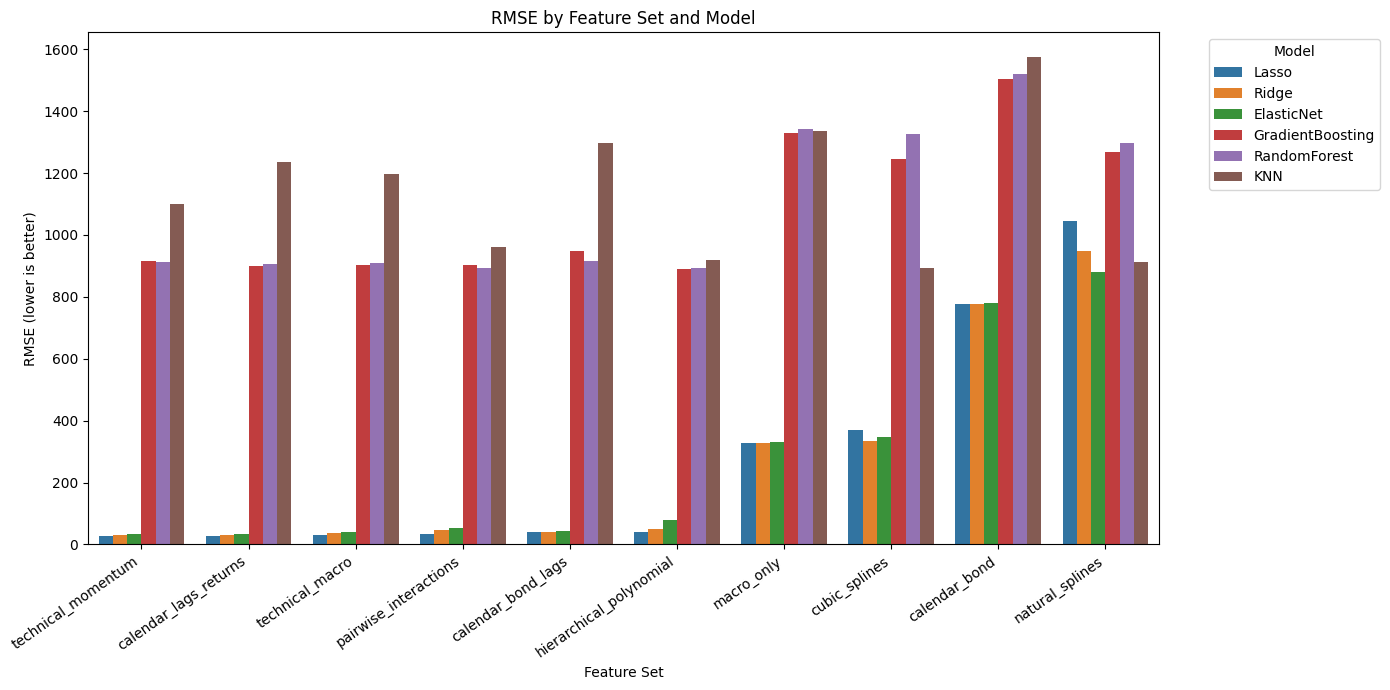

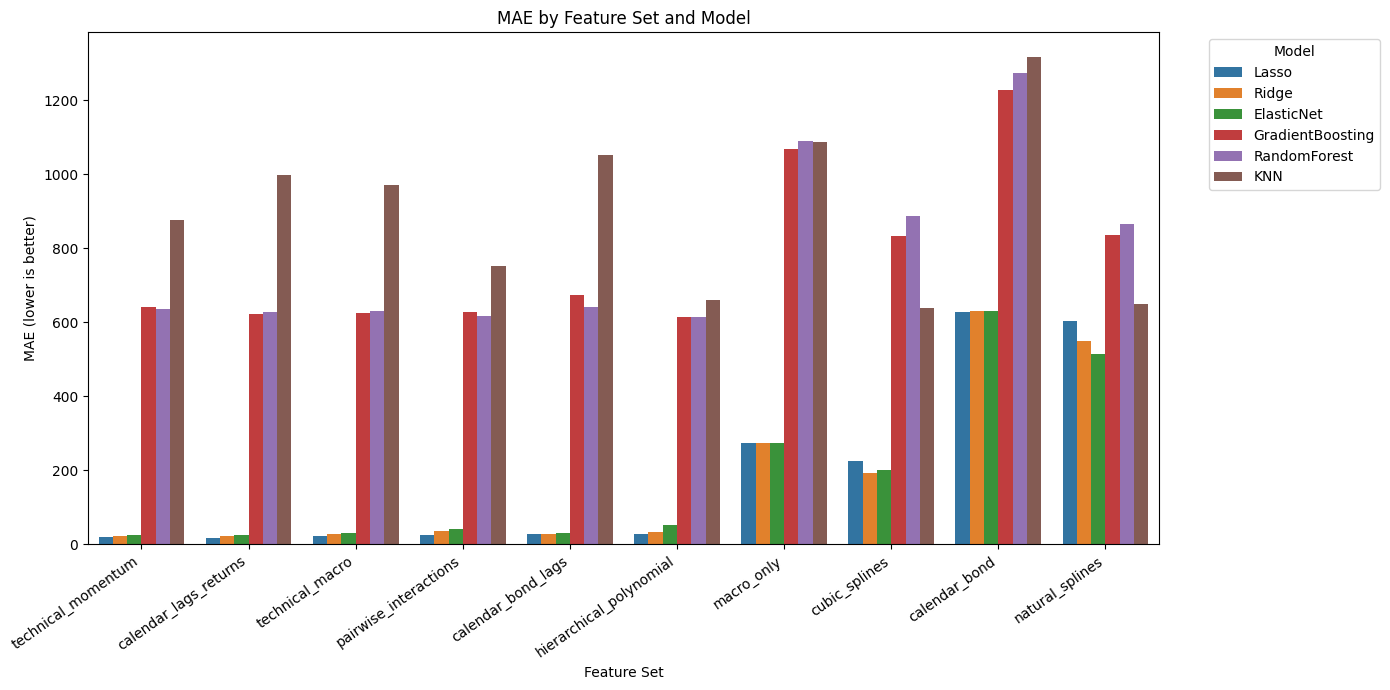

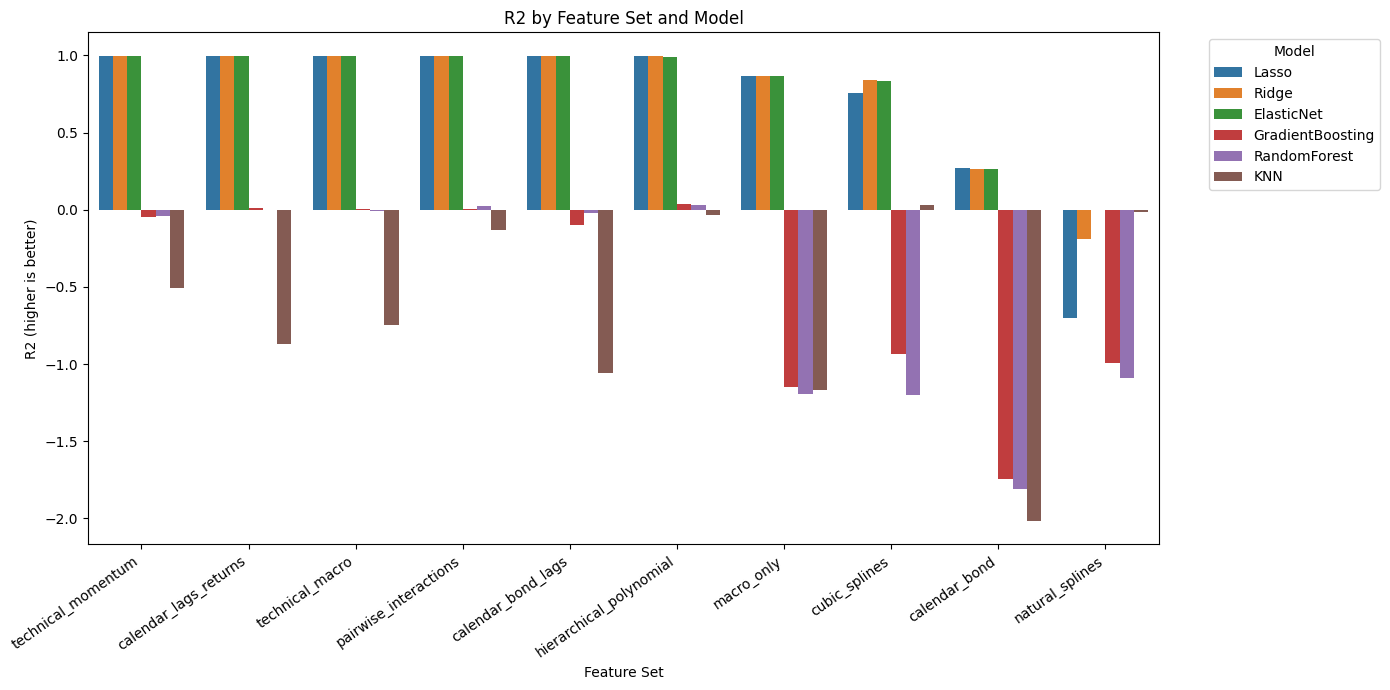

In [ ]:
# Graphical display of overall_summary

import matplotlib.pyplot as plt
import seaborn as sns

# Unstack so we can easily plot MAE, RMSE, R2 for each model/feature set pair
plot_df = overall_summary.reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(
    data=plot_df,
    x='FeatureSet',
    y='RMSE',
    hue='Model',
    palette='tab10'
)
plt.title('RMSE by Feature Set and Model')
plt.ylabel('RMSE (lower is better)')
plt.xlabel('Feature Set')
plt.xticks(rotation=35, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(
    data=plot_df,
    x='FeatureSet',
    y='MAE',
    hue='Model',
    palette='tab10'
)
plt.title('MAE by Feature Set and Model')
plt.ylabel('MAE (lower is better)')
plt.xlabel('Feature Set')
plt.xticks(rotation=35, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(
    data=plot_df,
    x='FeatureSet',
    y='R2',
    hue='Model',
    palette='tab10'
)
plt.title('R2 by Feature Set and Model')
plt.ylabel('R2 (higher is better)')
plt.xlabel('Feature Set')
plt.xticks(rotation=35, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.show()



Forecasting 126 business days | Feature set: calendar_bond, Model: GradientBoosting

Forecasting 126 business days | Feature set: calendar_bond, Model: RandomForest

Forecasting 126 business days | Feature set: calendar_bond, Model: KNN

Forecasting 126 business days | Feature set: calendar_bond, Model: Ridge

Forecasting 126 business days | Feature set: calendar_bond, Model: Lasso

Forecasting 126 business days | Feature set: calendar_bond, Model: ElasticNet

Forecasting 126 business days | Feature set: calendar_bond_lags, Model: GradientBoosting

Forecasting 126 business days | Feature set: calendar_bond_lags, Model: RandomForest

Forecasting 126 business days | Feature set: calendar_bond_lags, Model: KNN

Forecasting 126 business days | Feature set: calendar_bond_lags, Model: Ridge

Forecasting 126 business days | Feature set: calendar_bond_lags, Model: Lasso

Forecasting 126 business days | Feature set: calendar_bond_lags, Model: ElasticNet

Forecasting 126 business days | Feature

/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: 


Forecasting 126 business days | Feature set: technical_momentum, Model: RandomForest


/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: 


Forecasting 126 business days | Feature set: technical_momentum, Model: KNN


/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: 


Forecasting 126 business days | Feature set: technical_momentum, Model: Ridge


/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: 


Forecasting 126 business days | Feature set: technical_momentum, Model: Lasso


/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: 


Forecasting 126 business days | Feature set: technical_momentum, Model: ElasticNet


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.854e+05, tolerance: 8.587e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e+06, tolerance: 8.408e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e+06, tolerance: 8.501e


Forecasting 126 business days | Feature set: technical_macro, Model: GradientBoosting

Forecasting 126 business days | Feature set: technical_macro, Model: RandomForest

Forecasting 126 business days | Feature set: technical_macro, Model: KNN

Forecasting 126 business days | Feature set: technical_macro, Model: Ridge

Forecasting 126 business days | Feature set: technical_macro, Model: Lasso

Forecasting 126 business days | Feature set: technical_macro, Model: ElasticNet

Forecasting 126 business days | Feature set: macro_only, Model: GradientBoosting

Forecasting 126 business days | Feature set: macro_only, Model: RandomForest

Forecasting 126 business days | Feature set: macro_only, Model: KNN

Forecasting 126 business days | Feature set: macro_only, Model: Ridge

Forecasting 126 business days | Feature set: macro_only, Model: Lasso

Forecasting 126 business days | Feature set: macro_only, Model: ElasticNet

Forecasting 126 business days | Feature set: pairwise_interactions, Model: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e+06, tolerance: 8.752e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e+06, tolerance: 8.570e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+06, tolerance: 8.665e


Forecasting 126 business days | Feature set: hierarchical_polynomial, Model: GradientBoosting

Forecasting 126 business days | Feature set: hierarchical_polynomial, Model: RandomForest

Forecasting 126 business days | Feature set: hierarchical_polynomial, Model: KNN

Forecasting 126 business days | Feature set: hierarchical_polynomial, Model: Ridge

Forecasting 126 business days | Feature set: hierarchical_polynomial, Model: Lasso

Forecasting 126 business days | Feature set: hierarchical_polynomial, Model: ElasticNet


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e+06, tolerance: 8.752e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e+06, tolerance: 8.570e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+06, tolerance: 8.665e


Forecasting 126 business days | Feature set: cubic_splines, Model: GradientBoosting

Forecasting 126 business days | Feature set: cubic_splines, Model: RandomForest

Forecasting 126 business days | Feature set: cubic_splines, Model: KNN

Forecasting 126 business days | Feature set: cubic_splines, Model: Ridge

Forecasting 126 business days | Feature set: cubic_splines, Model: Lasso

Forecasting 126 business days | Feature set: cubic_splines, Model: ElasticNet

Forecasting 126 business days | Feature set: natural_splines, Model: GradientBoosting

Forecasting 126 business days | Feature set: natural_splines, Model: RandomForest

Forecasting 126 business days | Feature set: natural_splines, Model: KNN

Forecasting 126 business days | Feature set: natural_splines, Model: Ridge

Forecasting 126 business days | Feature set: natural_splines, Model: Lasso

Forecasting 126 business days | Feature set: natural_splines, Model: ElasticNet


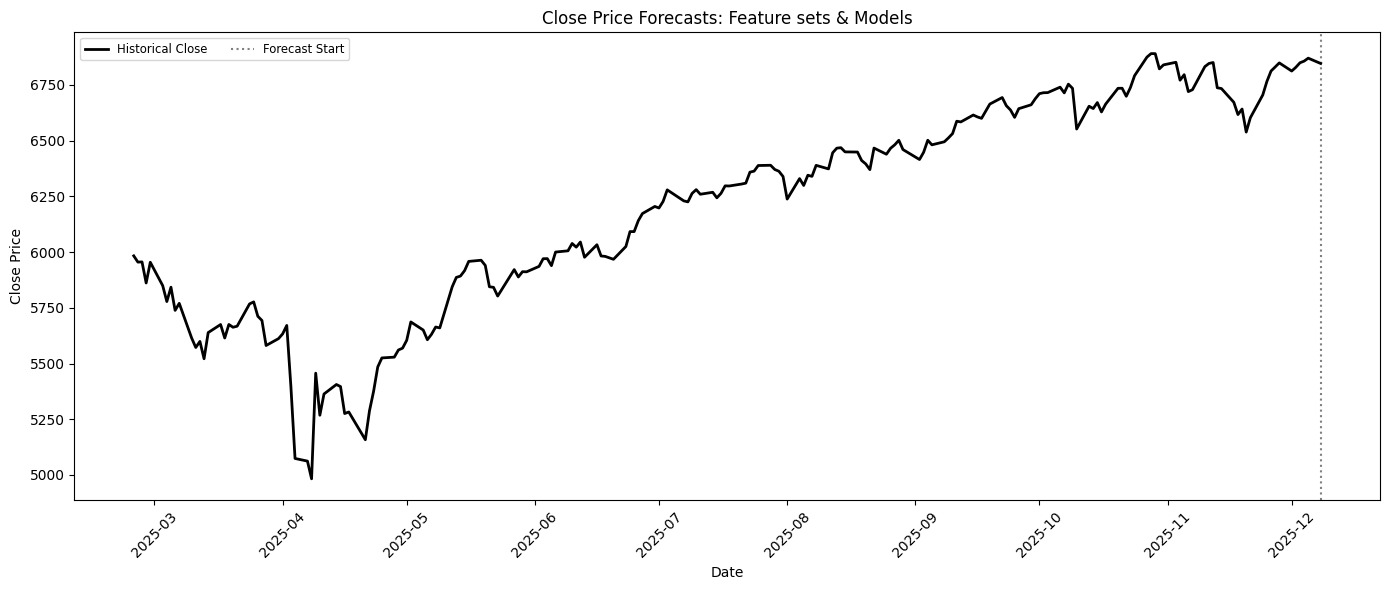

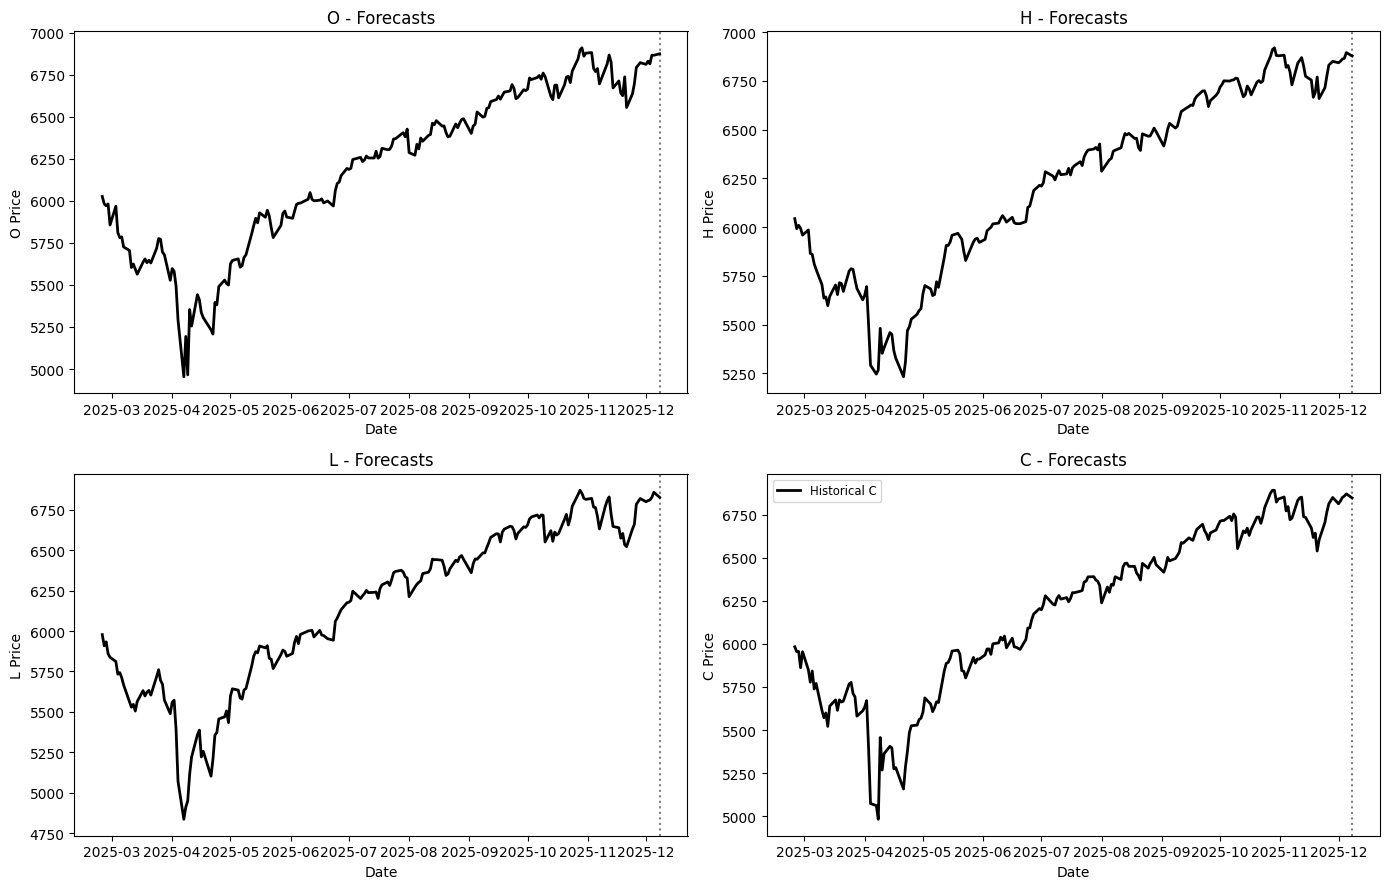

In [ ]:
# Forecast future 30 business days using all feature sets and models, collect forecasts and plot the results

#future_horizon = 30
future_horizon = 30

all_forecasts = []  # To store forecasts for each (feature_set, model)
feature_set_lookup = {cfg["name"]: cfg for cfg in feature_sets}

for feat_set_name, config in feature_set_lookup.items():
    builders = config["builders"]
    for model_name, model_factory in selected_models.items():
        print(f"\nForecasting {future_horizon} business days | Feature set: {feat_set_name}, Model: {model_name}")
        try:
            preds, fitted_model, used_feats = forecast_future_prices(
                base_df,
                builders,
                model_factory,
                horizon=future_horizon,
            )
            # Save metadata to the predictions DataFrame for later merging/comparison
            preds = preds.copy()
            preds["FeatureSet"] = feat_set_name
            preds["Model"] = model_name
            all_forecasts.append(preds)
        except Exception as e:
            print(f"Failed for FeatureSet={feat_set_name}, Model={model_name}: {e}")

if not all_forecasts:
    raise RuntimeError("No forecasts were generated.")

# Combine all forecasts
all_forecasts_df = pd.concat(all_forecasts)

# Plot: compare the Close forecasts of each (FeatureSet, Model)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
close_history = base_df.set_index("Date")["C"].tail(200)
plt.plot(close_history.index, close_history.values, label="Historical Close", c='k', linewidth=2, zorder=2)
for (feat_set, model_name), subdf in all_forecasts_df.groupby(["FeatureSet", "Model"]):
    # Only plot if "Date" column exists in subdf
    if "Date" in subdf.columns and "C" in subdf.columns:
        try:
            plt.plot(subdf["Date"], subdf["C"], linestyle="--", alpha=0.65, label=f"{feat_set} | {model_name}")
        except KeyError:
            print(f"Skipping {feat_set}|{model_name} in Close plot due to missing 'Date' or 'C'")
plt.axvline(close_history.index[-1], color="gray", linestyle=":", label="Forecast Start", zorder=1)
plt.title("Close Price Forecasts: Feature sets & Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.legend(loc="upper left", fontsize="small", ncol=2)
plt.tight_layout()
plt.show()

# Optionally plot Open, High, Low too
plt.figure(figsize=(14, 9))
ohlc_cols = ["O", "H", "L", "C"]
for col in ohlc_cols:
    plt.subplot(2,2,ohlc_cols.index(col)+1)
    # Check if "Date" exists in base_df columns before plotting
    if "Date" in base_df.columns:
        plt.plot(close_history.index, base_df.set_index("Date")[col].tail(200), label="Historical " + col, c='k', linewidth=2)
        for (feat_set, model_name), subdf in all_forecasts_df.groupby(["FeatureSet", "Model"]):
            # Only plot if "Date" and col exist in subdf
            if "Date" in subdf.columns and col in subdf.columns:
                try:
                    plt.plot(subdf["Date"], subdf[col], linestyle="--", alpha=0.65, label=f"{feat_set} | {model_name}")
                except KeyError:
                    print(f"Skipping {feat_set}|{model_name} in {col} plot due to missing 'Date' or '{col}'")
        plt.axvline(close_history.index[-1], color="gray", linestyle=":", zorder=1)
        plt.title(f"{col} - Forecasts")
        plt.xlabel("Date")
        plt.ylabel(f"{col} Price")
        if col == "C":
            plt.legend(loc="upper left", fontsize="small", ncol=2)
plt.tight_layout()
plt.show()



In [ ]:
# Identify best overall feature set + model combination (lowest average RMSE)
best_overall = overall_summary.reset_index().sort_values("RMSE").iloc[0]
best_overall

,0
FeatureSet,technical_momentum
Model,Lasso
MAE,18.9377
RMSE,27.4758
R2,0.9991


In [ ]:
# Forecast future 30 business days using the best-performing feature set / model
feature_set_lookup = {cfg["name"]: cfg for cfg in feature_sets}
forecast_feature_set = best_overall["FeatureSet"]
forecast_model_name = best_overall["Model"]

future_predictions, forecast_model, forecast_feature_cols = forecast_future_prices(
    base_df,
    feature_set_lookup[forecast_feature_set]["builders"],
    model_factories[forecast_model_name],
    horizon=30,
)

future_predictions.head()


/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[column].pct_change()
/tmp/ipython-input-3007827349.py:95: FutureWarning: 

,H,L,O,C
Date,,,,
2025-12-09,6934.4603,7109.5982,7125.0201,7111.6657
2025-12-10,7205.2004,7371.0564,7398.6812,7386.7460
2025-12-11,7479.0209,7653.0496,7684.2030,7672.5134
2025-12-12,7762.5828,7950.5801,7982.9368,7969.9909
2025-12-15,8052.9585,8269.0290,8295.8253,8281.3924


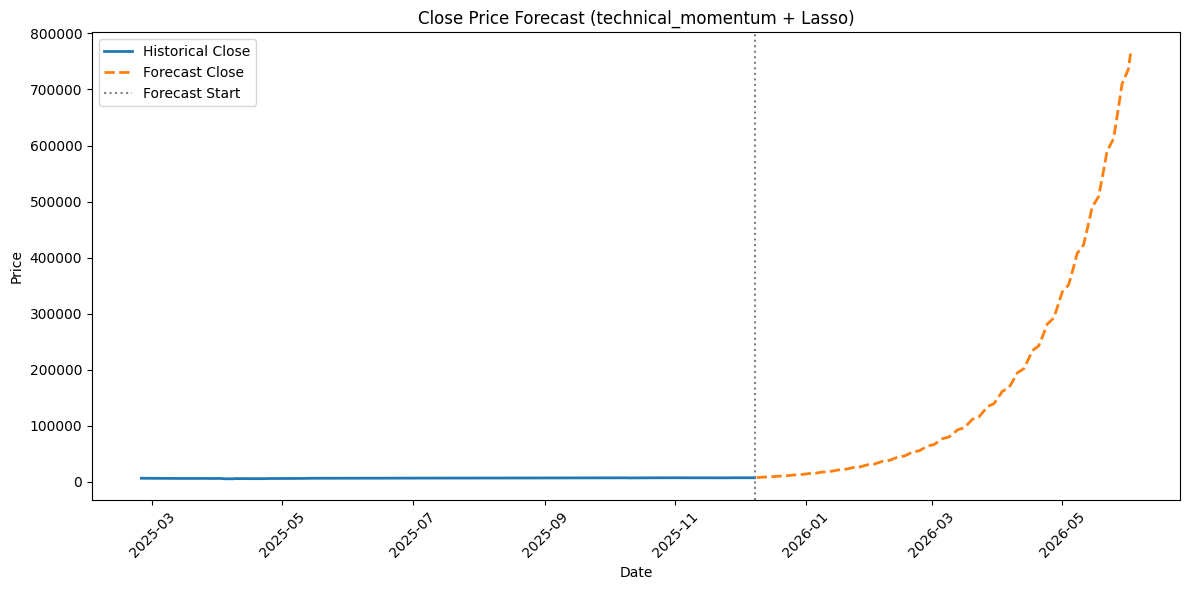

In [ ]:
# Plot recent Close price history with 30-day forecast
history_window = 200
close_history = base_df.set_index("Date")["C"].tail(history_window)
close_forecast = future_predictions["C"]

plt.figure(figsize=(12, 6))
plt.plot(close_history.index, close_history.values, label="Historical Close", linewidth=2)
plt.plot(close_forecast.index, close_forecast.values, label="Forecast Close", linestyle="--", linewidth=2)
plt.axvline(close_history.index[-1], color="gray", linestyle=":", label="Forecast Start")
plt.title(f"Close Price Forecast ({forecast_feature_set} + {forecast_model_name})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


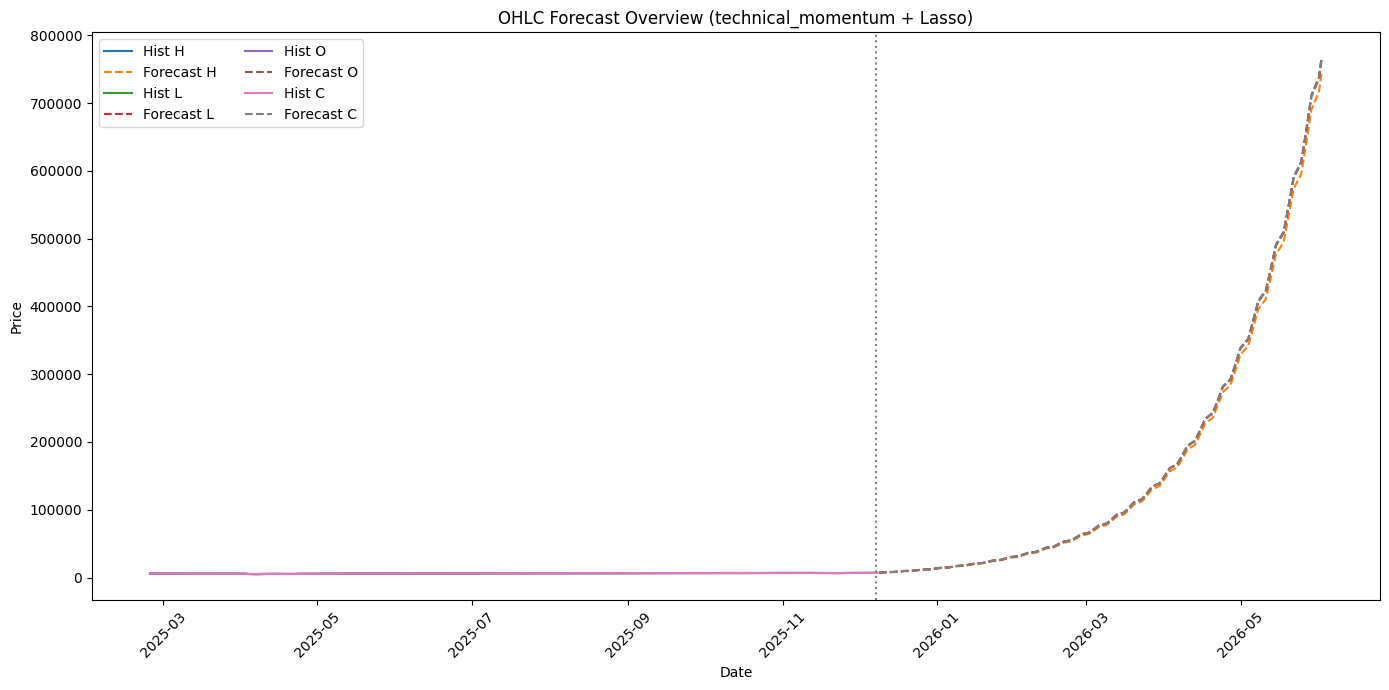

In [ ]:
# Multi-target forecast plot (OHLC)
plt.figure(figsize=(14, 7))
history_targets = base_df.set_index("Date")[target_cols].tail(history_window)
for col in target_cols:
    plt.plot(history_targets.index, history_targets[col], label=f"Hist {col}")
    plt.plot(future_predictions.index, future_predictions[col], linestyle="--", label=f"Forecast {col}")

plt.axvline(history_targets.index[-1], color="gray", linestyle=":")
plt.title(f"OHLC Forecast Overview ({forecast_feature_set} + {forecast_model_name})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


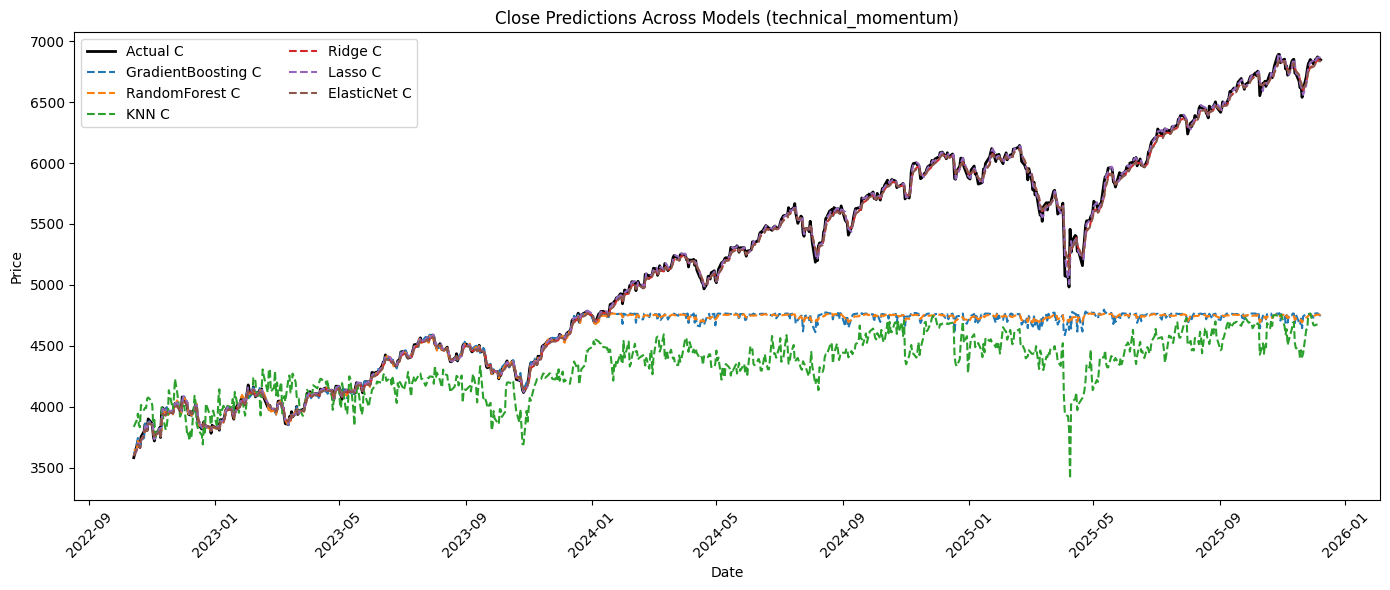

In [ ]:
# Plot Close predictions from all models within the best feature set
all_models_result = experiment_results[forecast_feature_set]
dates_eval = all_models_result["features_frame"].loc[all_models_result["X_test"].index, "Date"]
actual_close = all_models_result["y_test"]["C"]

plt.figure(figsize=(14, 6))
plt.plot(dates_eval, actual_close, label="Actual C", linewidth=2, color="black")
for model_name, preds in all_models_result["predictions"].items():
    plt.plot(dates_eval, preds["C"], linestyle="--", label=f"{model_name} C")

plt.title(f"Close Predictions Across Models ({forecast_feature_set})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Best-performing model (by lowest average RMSE) within each feature set
best_models_by_feature = (
    overall_summary
    .reset_index()
    .sort_values(by=["FeatureSet", "RMSE"])
    .groupby("FeatureSet")
    .first()
)
best_models_by_feature


,Model,MAE,RMSE,R2
FeatureSet,,,,
calendar_bond,Lasso,628.4474,776.0797,0.2677
calendar_bond_lags,Lasso,27.7453,39.9723,0.9980
calendar_lags_returns,Lasso,18.5981,27.6090,0.9991
cubic_splines,Ridge,192.2269,333.9306,0.8437
hierarchical_polynomial,Lasso,27.9128,40.4253,0.9979
macro_only,Lasso,273.5125,328.1300,0.8691
natural_splines,ElasticNet,513.1554,880.6222,-0.0024
pairwise_interactions,Lasso,26.5214,35.2795,0.9984
technical_macro,Lasso,23.4619,31.2513,0.9988


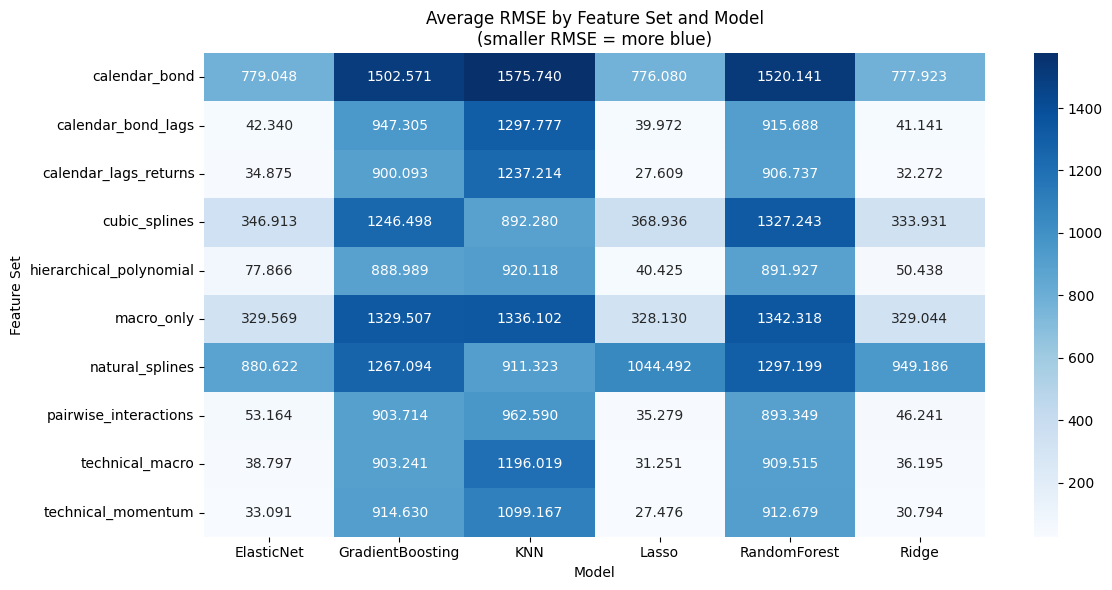

In [ ]:
# Visualization: average RMSE by feature set and model
rmse_matrix = overall_summary["RMSE"].unstack("Model")
plt.figure(figsize=(12, 6))
# For 'Blues', smaller = lower = more blue; higher = whiter (so default is correct).
sns.heatmap(
    rmse_matrix,
    annot=True,
    fmt="0.3f",
    cmap="Blues",
    vmax=rmse_matrix.values.max(),   # maximum RMSE = least blue (whitest)
    vmin=rmse_matrix.values.min()    # minimum RMSE = most blue
)
plt.title("Average RMSE by Feature Set and Model\n(smaller RMSE = more blue)")
plt.ylabel("Feature Set")
plt.tight_layout()
plt.show()


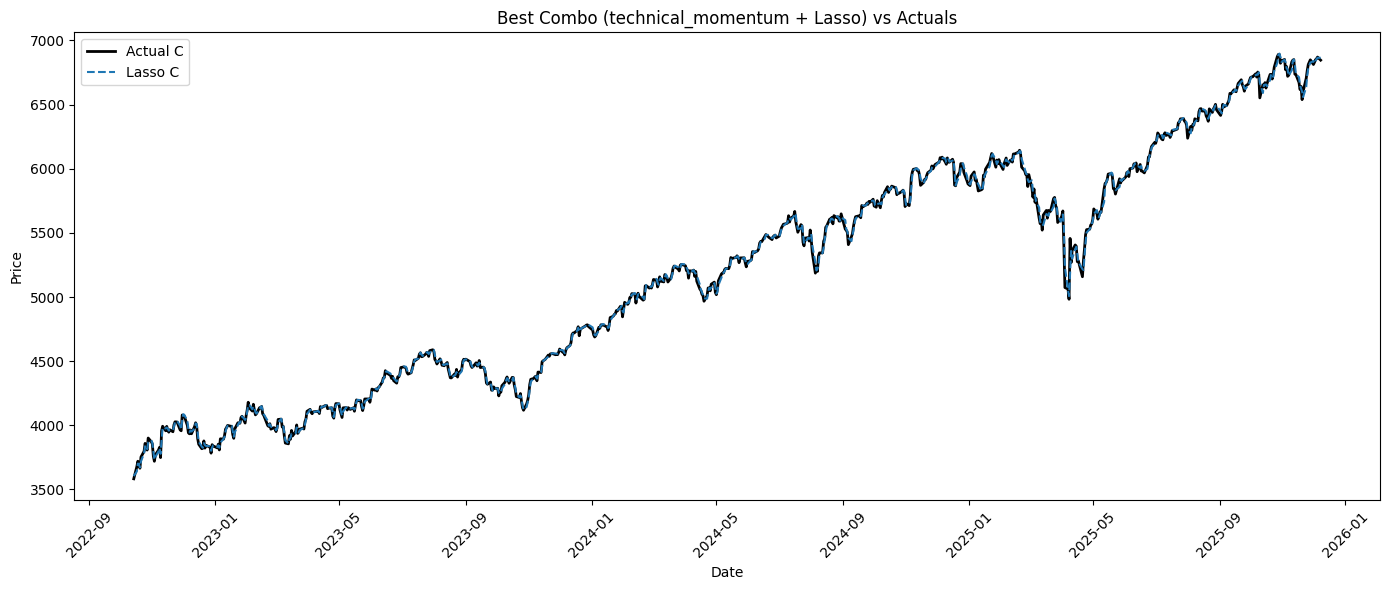

In [ ]:
# Plot actual vs predicted for the best overall combination
best_feature_set = best_overall["FeatureSet"]
best_model_name = best_overall["Model"]
best_result = experiment_results[best_feature_set]

dates_test = best_result["features_frame"].loc[best_result["X_test"].index, "Date"]
actuals = best_result["y_test"].copy()
predictions = best_result["predictions"][best_model_name]

target_to_plot = "C"
plt.figure(figsize=(14, 6))
plt.plot(dates_test, actuals[target_to_plot], label=f"Actual {target_to_plot}", linewidth=2, color="black")
plt.plot(dates_test, predictions[target_to_plot], label=f"{best_model_name} {target_to_plot}", linestyle="--")
plt.title(f"Best Combo ({best_feature_set} + {best_model_name}) vs Actuals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Detailed metrics for the best combination across all targets
best_metrics_detail = metrics_comparison_df[
    (metrics_comparison_df["FeatureSet"] == best_feature_set)
    & (metrics_comparison_df["Model"] == best_model_name)
]
best_metrics_detail


,Model,Target,MAE,RMSE,R2,FeatureSet
88,Lasso,H,21.0488,29.6533,0.9989,technical_momentum
89,Lasso,L,19.9594,28.4105,0.9990,technical_momentum
90,Lasso,O,16.2243,24.4874,0.9993,technical_momentum
91,Lasso,C,18.5184,27.3518,0.9991,technical_momentum


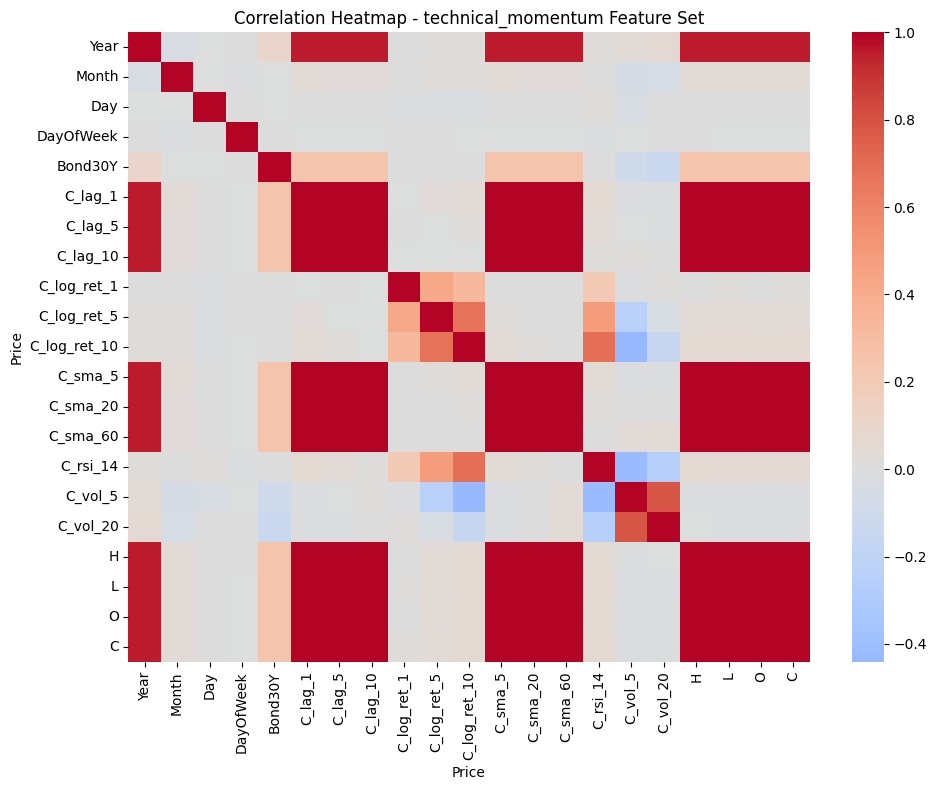

In [ ]:
# Correlation heatmap for the best feature set
best_features_frame = best_result["features_frame"].copy()
heatmap_cols = best_result["feature_columns"] + target_cols
plt.figure(figsize=(10, 8))
sns.heatmap(best_features_frame[heatmap_cols].corr(), annot=False, cmap="coolwarm", center=0)
plt.title(f"Correlation Heatmap - {best_feature_set} Feature Set")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 📊 所有模型的迭代预测可视化（单张图）
# ============================================================

def plot_all_models_forecasts(
    base_df: pd.DataFrame,
    feature_funcs: List[FeatureBuilder],
    model_factories: Dict[str, Callable[[], MultiOutputRegressor]],
    horizon: int = 30,
    history_window: int = 200,
    target_col: str = "C",
    macro_data_dict: Dict[str, pd.DataFrame] = None,
    title: str = "所有模型的迭代预测对比"
):
    """
    在一张图上绘制所有模型的迭代预测结果
    
    Parameters:
    -----------
    base_df : pd.DataFrame
        基础数据框
    feature_funcs : List[FeatureBuilder]
        特征构建函数列表
    model_factories : Dict[str, Callable]
        模型工厂字典
    horizon : int
        预测时间范围（天数）
    history_window : int
        历史数据窗口（天数）
    target_col : str
        目标列名（默认"C"）
    macro_data_dict : Dict[str, pd.DataFrame]
        宏观数据字典
    title : str
        图表标题
    """
    # 准备历史数据
    if "Date" in base_df.columns:
        base_df_indexed = base_df.set_index("Date")
    else:
        base_df_indexed = base_df
    
    history_data = base_df_indexed[target_col].tail(history_window)
    last_date = history_data.index[-1]
    
    # 存储所有模型的预测结果
    all_predictions = {}
    
    print(f"开始为 {len(model_factories)} 个模型生成预测...")
    
    # 对每个模型进行预测
    for model_name, model_factory in model_factories.items():
        try:
            print(f"  正在预测: {model_name}...")
            predictions, model, features = forecast_future_prices(
                base_df,
                feature_funcs,
                model_factory,
                horizon=horizon,
                macro_data_dict=macro_data_dict,
            )
            all_predictions[model_name] = predictions[target_col]
            print(f"    ✅ {model_name} 预测完成")
        except Exception as e:
            print(f"    ⚠️ {model_name} 预测失败: {e}")
            continue
    
    if not all_predictions:
        print("❌ 没有成功生成任何预测，无法绘制图表")
        return
    
    # 创建图表
    plt.figure(figsize=(16, 8))
    
    # 绘制历史数据
    plt.plot(
        history_data.index, 
        history_data.values, 
        label="历史数据", 
        linewidth=2.5, 
        color="black",
        zorder=10
    )
    
    # 为每个模型绘制预测结果
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_predictions)))
    for idx, (model_name, pred_series) in enumerate(all_predictions.items()):
        plt.plot(
            pred_series.index,
            pred_series.values,
            label=f"{model_name} 预测",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
            color=colors[idx],
            zorder=5
        )
    
    # 添加预测起始线
    plt.axvline(
        last_date, 
        color="gray", 
        linestyle=":", 
        linewidth=2,
        label="预测起始点",
        zorder=8
    )
    
    # 设置图表属性
    plt.title(f"{title}\n(预测时间范围: {horizon}天)", fontsize=14, fontweight="bold")
    plt.xlabel("日期", fontsize=12)
    plt.ylabel(f"{target_col} 价格", fontsize=12)
    plt.legend(loc="best", fontsize=9, ncol=2, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle="--")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    # 显示统计信息
    print(f"\n📊 预测统计信息:")
    print(f"  成功预测的模型数: {len(all_predictions)}")
    print(f"  预测时间范围: {horizon} 天")
    print(f"  预测起始日期: {last_date.date()}")
    if all_predictions:
        first_pred = list(all_predictions.values())[0]
        print(f"  预测结束日期: {first_pred.index[-1].date()}")
    
    plt.show()
    
    return all_predictions


# 使用最佳特征集进行预测（如果已运行实验）
# 如果没有运行实验，可以使用默认特征集
try:
    # 尝试使用最佳特征集
    if 'best_overall' in globals() and 'feature_set_lookup' in globals():
        best_feature_set = best_overall["FeatureSet"]
        selected_feature_funcs = feature_set_lookup[best_feature_set]["builders"]
        print(f"使用最佳特征集: {best_feature_set}")
    else:
        # 使用默认特征集（技术指标+宏观）
        from functools import partial
        lag_features_basic = partial(add_lag_features, column="C", lags=(1, 5, 10))
        log_returns_basic = partial(add_return_features, column="C", windows=(1, 5, 10), log=True)
        ma_features_basic = partial(add_moving_average_features, column="C", windows=(5, 20, 60))
        rsi_feature_basic = partial(add_rsi_feature, column="C", window=14)
        vol_features_basic = partial(add_volatility_features, column="C", windows=(5, 20))
        
        selected_feature_funcs = [
            add_calendar_features,
            add_bond_feature,
            lag_features_basic,
            log_returns_basic,
            ma_features_basic,
            rsi_feature_basic,
            vol_features_basic,
        ]
        print("使用默认特征集（技术指标）")
    
    # 选择要使用的模型（排除XGBoost如果导入失败）
    models_to_plot = {}
    for name, factory in model_factories.items():
        if name == "XGBoost":
            try:
                from xgboost import XGBRegressor
                models_to_plot[name] = factory
            except Exception as e:
                print(f"⚠️ 跳过 {name}（XGBoost导入失败: {type(e).__name__}）")
                if "OpenMP" in str(e) or "libomp" in str(e):
                    print(f"   提示: 在macOS上运行 'brew install libomp' 来安装OpenMP运行时")
                continue
        else:
            models_to_plot[name] = factory
    
    # 生成所有模型的预测可视化
    all_model_predictions = plot_all_models_forecasts(
        base_df=base_df,
        feature_funcs=selected_feature_funcs,
        model_factories=models_to_plot,
        horizon=30,
        history_window=200,
        target_col="C",
        macro_data_dict=macro_data if 'macro_data' in globals() else None,
        title="所有模型的迭代预测对比"
    )
    
except Exception as e:
    print(f"❌ 生成预测可视化时出错: {e}")
    print("请确保已运行前面的cell并定义了必要的变量")

